In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob
import pretty_midi
import librosa

import midi_manipulation

C:\Users\anchora\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anchora\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anchora\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\anchora\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [2]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in files:
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            #if np.array(song).shape[0] > 50:
            songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [3]:
def get_chromas(songs):
    chromas = []
    for song in songs: 
        chroma = np.zeros(shape=(np.shape(song)[0], 12))
        for i in range(np.shape(song)[0]):
            for j in range(78):
                if song[i][j] == 1:
                    chroma[i][np.mod(j,12)] += 1
        chromas.append(chroma)
                
    return chromas

In [4]:
songs = get_songs('Pop_Music_Midi')
chromas = get_chromas(songs)
print ("{} songs processed".format(len(songs)))
print ("{} songs processed".format(len(chromas)))

122 songs processed
122 songs processed


In [5]:
print(np.shape(songs[40]))

(65, 156)


In [6]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #This is the number of timesteps that we will create at a time
X_dim = 2*note_range*num_timesteps #This is the size of the visible layer. 
Z_dim = 12*num_timesteps
n_hidden = 50 #This is the size of the hidden layer

print(X_dim,Z_dim)

624 48


In [7]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [8]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

# D_W1 = tf.Variable(xavier_init([784, 999]))
D_W1 = tf.Variable(xavier_init([X_dim+Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))

D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [9]:
# set Z
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [10]:
# def sample_Z(m, n):
#     return np.random.uniform(-1., 1., size=[m, n])

In [11]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [12]:
def discriminator(x,c):
    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x,c],1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [13]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
#         plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [14]:
print (np.shape(Z))

(?, 48)


In [15]:
G_sample = generator(Z)

In [16]:
print(note_range)

78


In [17]:
D_real, D_logit_real = discriminator(X,Z)

In [18]:
D_fake, D_logit_fake = discriminator(G_sample,Z)

In [19]:
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
G_loss = G_loss_fake + 100*G_loss_L1

W0227 23:28:41.289891  1708 deprecation.py:323] From C:\Users\anchora\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [21]:
if not os.path.exists('out/'):
    os.makedirs('out/')

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [23]:
# for song in songs:
#         # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
#         # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
#         song = np.array(song)
#         song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
#         song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
#         # Train the RBM on batch_size examples at a time

In [24]:
# i = 0

In [25]:
print(chromas[0].shape[0], chromas[0].shape[1])
print(songs[0].shape[0], songs[0].shape[1])

257 12
257 156


In [27]:
i = 0
num_epochs = 1000000
batch_size = 10
trainingEnded = False

while i <= num_epochs and trainingEnded == False:
    if(trainingEnded == True):
        break
    
    
    for song, chroma in zip(songs, chromas):
        if(trainingEnded == True):
            break
        
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
       
        song = np.array(song)     
        #print(i, np.shape(song))
        
        song_steps = np.floor(song.shape[0]/num_timesteps).astype(int)
        song = song[:song_steps*num_timesteps]
        #print(i, np.shape(song))

        song = np.reshape(song, [song_steps, song.shape[1]*num_timesteps])
        #print(i, np.shape(song))
        
        chroma = np.array(chroma)
        #print(i, np.shape(chroma))

        #chroma = chroma[:np.floor(chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
        chroma = chroma[:song_steps*num_timesteps]
        #print(i, np.shape(song))
 
        #chroma = np.reshape(chroma, [int(chroma.shape[0]/num_timesteps), chroma.shape[1]*num_timesteps])
        chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])
        #print(i, np.shape(song))
        
        
       
        #print(i, len(song), batch_size)
                    
        batch_size = min(batch_size,len(song))

        # Train the RBM on batch_size examples at a time
        for ind in range(0, len(song), batch_size):
            if(trainingEnded == True):
                break
            
            X_mb = song[ind:ind+batch_size]
            ch = chroma[ind:ind+batch_size]
#            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch}) #is this where chroma is part of loss? girl idk
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})
    
            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                dloss = ('D_Loss: {:.4}'. format(D_loss_curr))
                gloss = ('G_Loss: {:.4}'. format(G_loss_curr))
                print(dloss)
                print(gloss)
                
#                 sheet1.write((int)(i/1000), 0, dloss)
#                 sheet1.write((int)(i/1000), 1, gloss)

#             samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})
                samples = sess.run(G_sample, feed_dict={Z: ch}) #or here? lol i think it's here actually
#                 print(np.shape(samples), np.shape(ch))
        
                S = np.reshape(samples, (ch.shape[0]*num_timesteps, 2*note_range))
                thresh_S = S>=0.5
#                 plt.figure(figsize=(12,2))
#                 plt.subplot(1,2,1)
#                 plt.imshow(S)
#                 plt.subplot(1,2,2)
                #plt.imshow(thresh_S)
                C = np.reshape(ch, (ch.shape[0]*num_timesteps, 12))
#                 plt.imshow(C)
#                 plt.tight_layout()
#                 plt.pause(0.1)

                print(np.shape(S))
                print(np.shape(thresh_S))
                midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
            
                if(i >= 100000 and D_loss_curr >= 0.5 and G_loss_curr <= 4):
                    trainingEnded = True
                    
                if(trainingEnded == True):
                    break
#                 print(i)
            i += 1

Iter: 0
D_Loss: 0.001937
G_Loss: 9.877
(40, 156)
(40, 156)
Iter: 1000
D_Loss: 0.002551
G_Loss: 13.42
(40, 156)
(40, 156)
Iter: 2000
D_Loss: 0.0002172
G_Loss: 15.35
(40, 156)
(40, 156)
Iter: 3000
D_Loss: 0.1201
G_Loss: 11.88
(40, 156)
(40, 156)
Iter: 4000
D_Loss: 2.944e-05
G_Loss: 15.15
(40, 156)
(40, 156)
Iter: 5000
D_Loss: 0.0002454
G_Loss: 13.23
(40, 156)
(40, 156)
Iter: 6000
D_Loss: 0.01011
G_Loss: 8.465
(8, 156)
(8, 156)
Iter: 7000
D_Loss: 0.0164
G_Loss: 8.674
(40, 156)
(40, 156)
Iter: 8000
D_Loss: 0.0001383
G_Loss: 24.69
(40, 156)
(40, 156)
Iter: 9000
D_Loss: 3.111e-05
G_Loss: 17.7
(40, 156)
(40, 156)
Iter: 10000
D_Loss: 2.915e-05
G_Loss: 28.69
(40, 156)
(40, 156)
Iter: 11000
D_Loss: 1.08e-06
G_Loss: 18.76
(40, 156)
(40, 156)
Iter: 12000
D_Loss: 2.329e-06
G_Loss: 26.84
(24, 156)
(24, 156)
Iter: 13000
D_Loss: 4.174e-05
G_Loss: 15.76
(40, 156)
(40, 156)
Iter: 14000
D_Loss: 3.289e-05
G_Loss: 14.76
(40, 156)
(40, 156)
Iter: 15000
D_Loss: 7.758e-07
G_Loss: 20.15
(40, 156)
(40, 156)
Ite

Iter: 129000
D_Loss: 7.778e-15
G_Loss: 43.16
(40, 156)
(40, 156)
Iter: 130000
D_Loss: 2.361e-13
G_Loss: 38.35
(40, 156)
(40, 156)
Iter: 131000
D_Loss: 1.639e-06
G_Loss: 33.77
(40, 156)
(40, 156)
Iter: 132000
D_Loss: 7.11e-11
G_Loss: 27.98
(40, 156)
(40, 156)
Iter: 133000
D_Loss: 5.2e-08
G_Loss: 19.34
(8, 156)
(8, 156)
Iter: 134000
D_Loss: 6.315e-06
G_Loss: 32.1
(40, 156)
(40, 156)
Iter: 135000
D_Loss: 9.73e-12
G_Loss: 38.41
(40, 156)
(40, 156)
Iter: 136000
D_Loss: 9.401e-05
G_Loss: 26.32
(40, 156)
(40, 156)
Iter: 137000
D_Loss: 1.981e-06
G_Loss: 28.26
(40, 156)
(40, 156)
Iter: 138000
D_Loss: 9.671e-10
G_Loss: 27.3
(40, 156)
(40, 156)
Iter: 139000
D_Loss: 4.446e-09
G_Loss: 38.0
(28, 156)
(28, 156)
Iter: 140000
D_Loss: 3.674e-09
G_Loss: 36.37
(40, 156)
(40, 156)
Iter: 141000
D_Loss: 0.853
G_Loss: 7.388
(40, 156)
(40, 156)
Iter: 142000
D_Loss: 1.574
G_Loss: 3.004
(24, 156)
(24, 156)


In [28]:
# Constants

"""Radiuses of different circles (defined such to reflect the
tonal distance through the euclidian distance on tonnetz vectors)
"""

r_fifth = 1.
r_minor_thirds = 1.
r_major_thirds = 0.5

def _make_tonnetz_matrix():
    """Return the tonnetz projection matrix."""
    pi = np.pi
    chroma = np.arange(12)

    # Define each row of the transform matrix
    fifth_x = r_fifth*(np.sin((7*pi/6) * chroma))
    fifth_y = r_fifth*(np.cos((7*pi/6) * chroma))
    minor_third_x = r_minor_thirds*(np.sin(3*pi/2 * chroma))
    minor_third_y = r_minor_thirds*(np.cos(3*pi/2 * chroma))
    major_third_x = r_major_thirds*(np.sin(2*pi/3 * chroma))
    major_third_y = r_major_thirds*(np.cos(2*pi/3 * chroma))

    # Return the tonnetz matrix
    return np.vstack((fifth_x, fifth_y,
                      minor_third_x, minor_third_y,
                      major_third_x, major_third_y))

In [29]:
__TONNETZ_MATRIX = _make_tonnetz_matrix()

In [30]:
def _to_tonnetz(chromagram):  
    chromagram = chromagram.transpose()
    #chromagram = np.resize(chromagram, (12, 256))
    """Project a chromagram on the tonnetz.
    Returned value is normalized to prevent numerical instabilities.  
    """
    if np.sum(np.abs(chromagram)) == 0.:
        # The input is an empty chord, return zero. 
        return np.zeros(6)
    
    _tonnetz = np.dot(__TONNETZ_MATRIX, chromagram)
    one_norm = np.sum(np.abs(_tonnetz))  # Non-zero value
    _tonnetz = _tonnetz / float(one_norm) # Normalize tonnetz vector
    return _tonnetz

In [31]:
def distance(a, b):
    """Compute tonnetz-distance between two chromagrams.
    
    ----
    >>> C = np.zeros(12)
    >>> C[0] = 1
    >>> D = np.zeros(12)
    >>> D[2] = 1
    >>> G = np.zeros(12)
    >>> G[7] = 1
    The distance is zero on equivalent chords
    >>> distance(C, C) == 0
    True
    The distance is symetric
    >>> distance(C, D) == distance(D, C)
    True
    >>> distance(C, D) > 0
    True
    >>> distance(C, G) < distance(C, D)
    True
    """
    [a_tonnetz, b_tonnetz] = [_to_tonnetz(x) for x in [a, b]]
    return np.linalg.norm(b_tonnetz - a_tonnetz)

In [32]:
print(np.shape(chromas[1]))

(385, 12)


In [33]:
test_song = get_songs("classicaltrimmedfortime")
test_chromaz = get_chromas(test_song)

In [34]:
print(np.shape(test_chromaz[1]))

(992, 12)


0 (1121, 12)
(280, 48) (6, 624)
24
(1120, 156) (1120, 12)


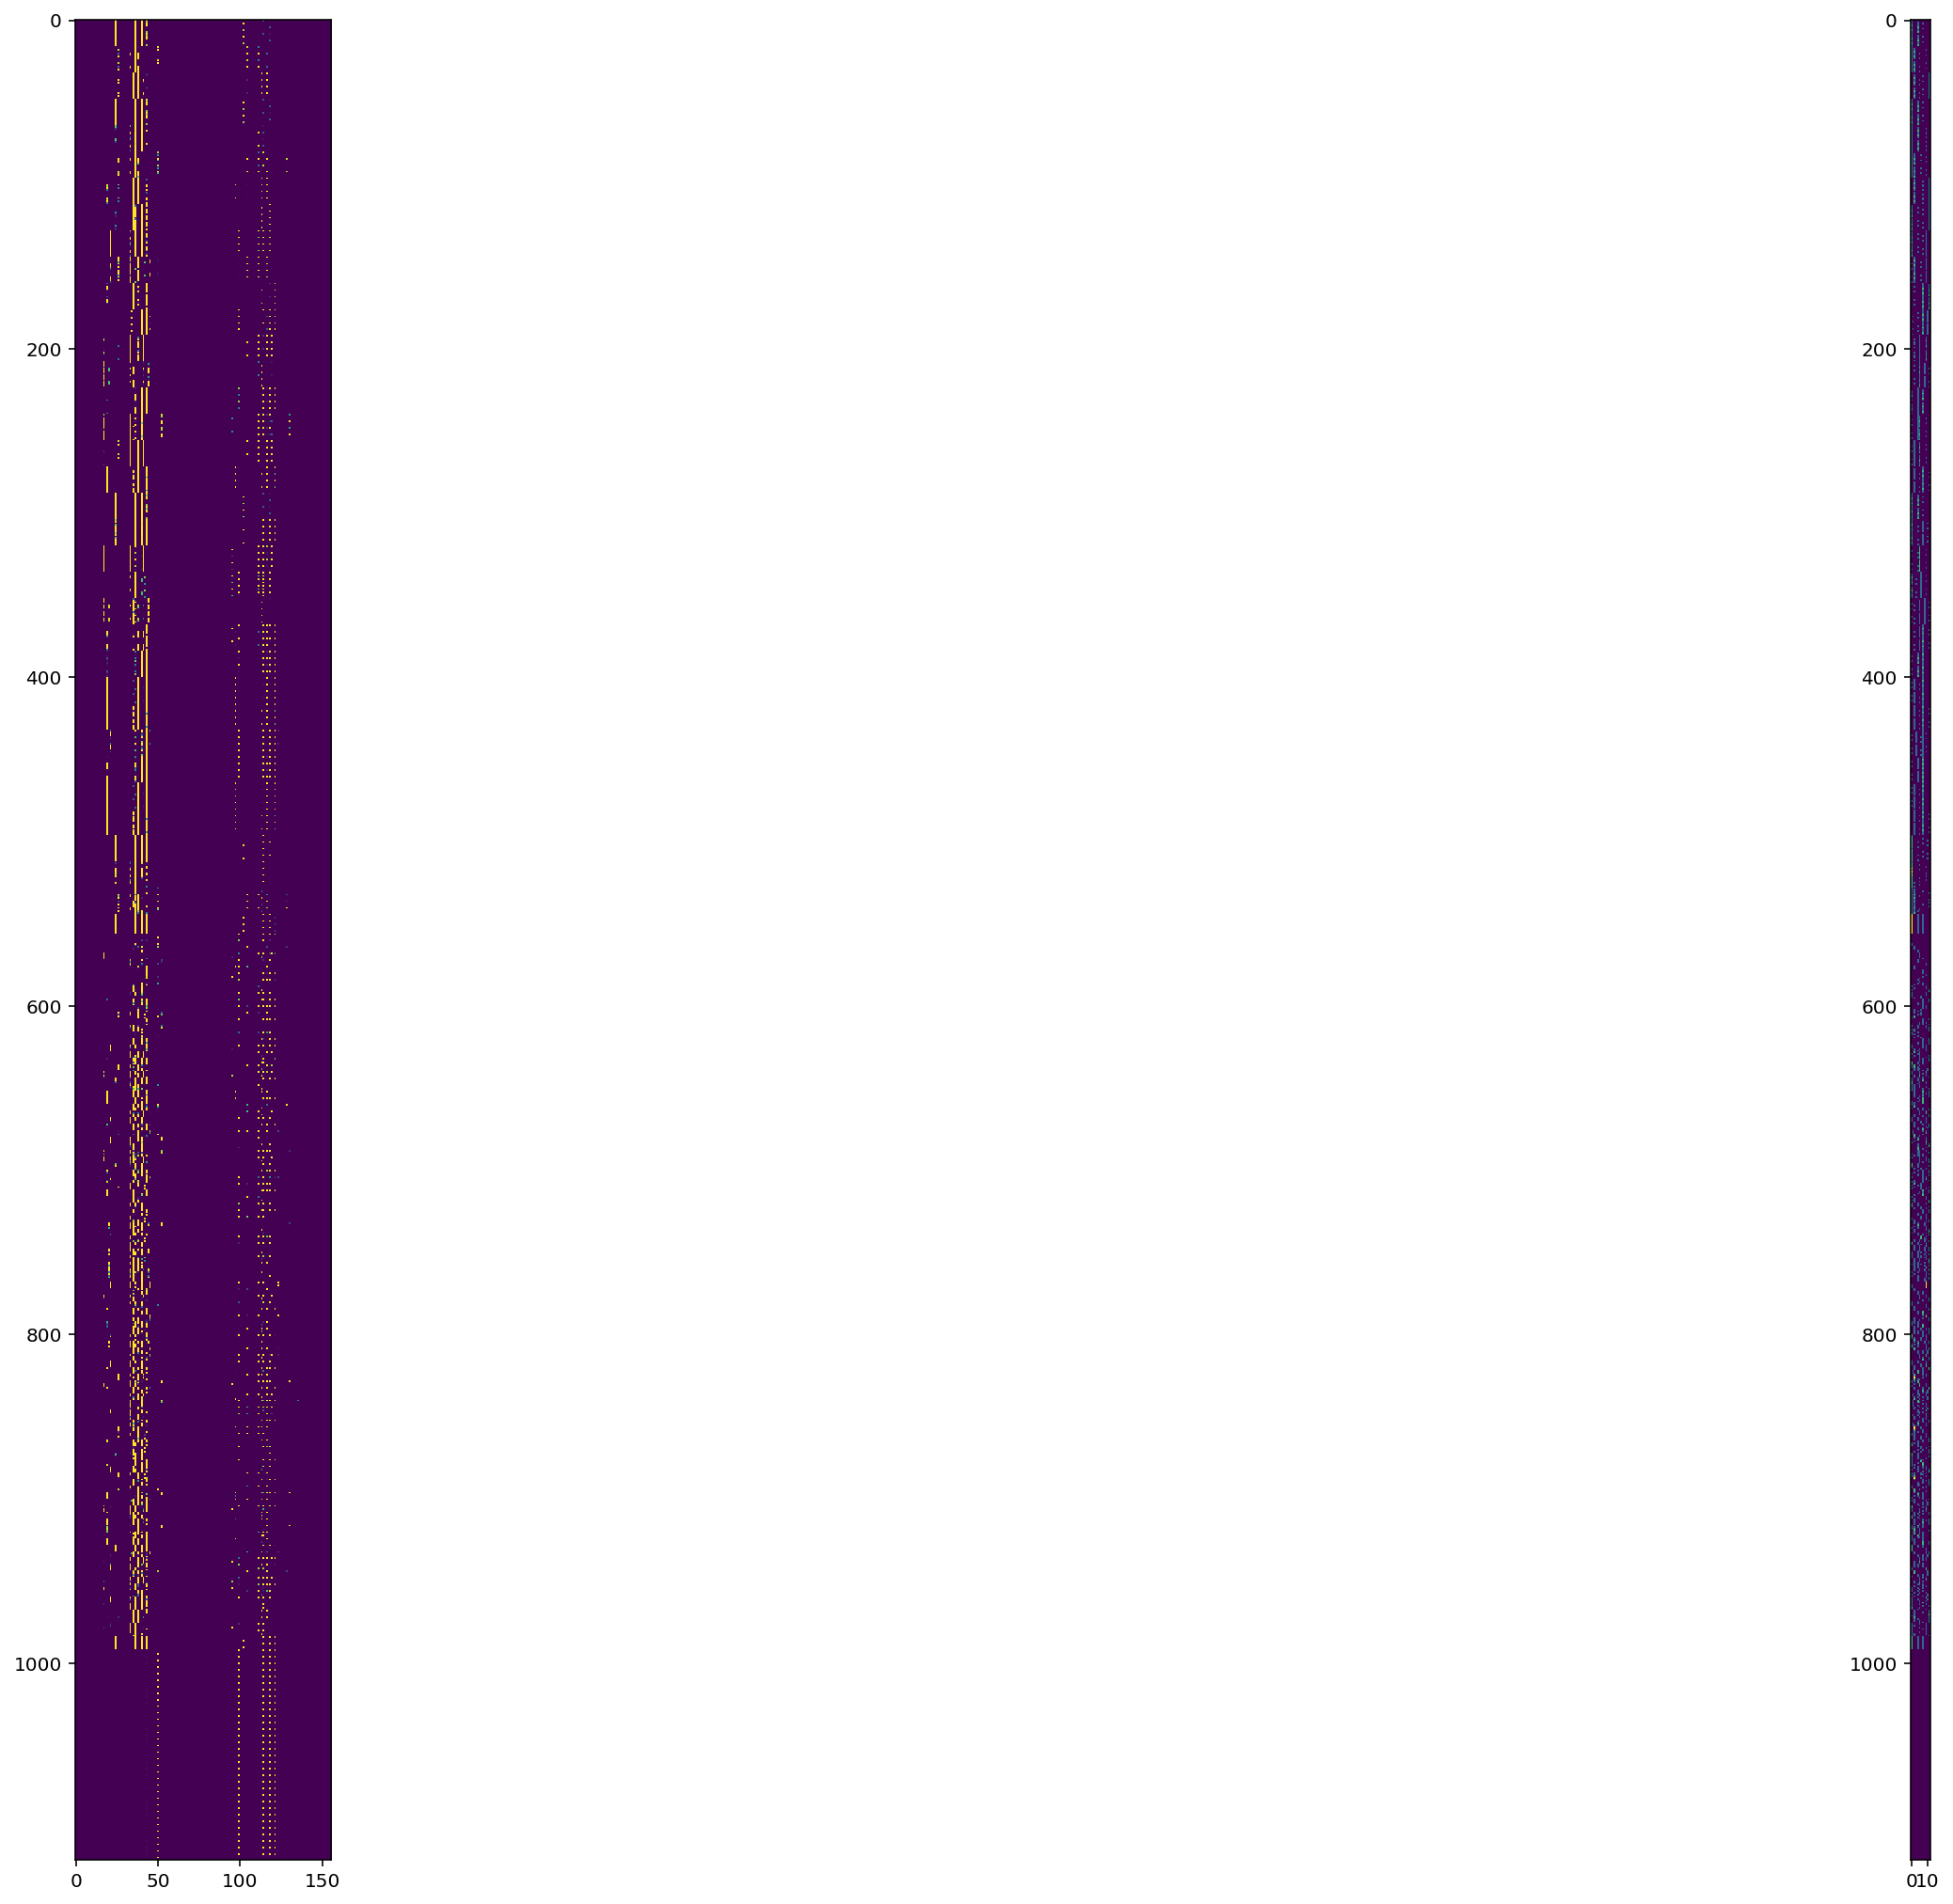

1120
0.0
1 (992, 12)
(248, 48) (6, 624)
24
(992, 156) (992, 12)


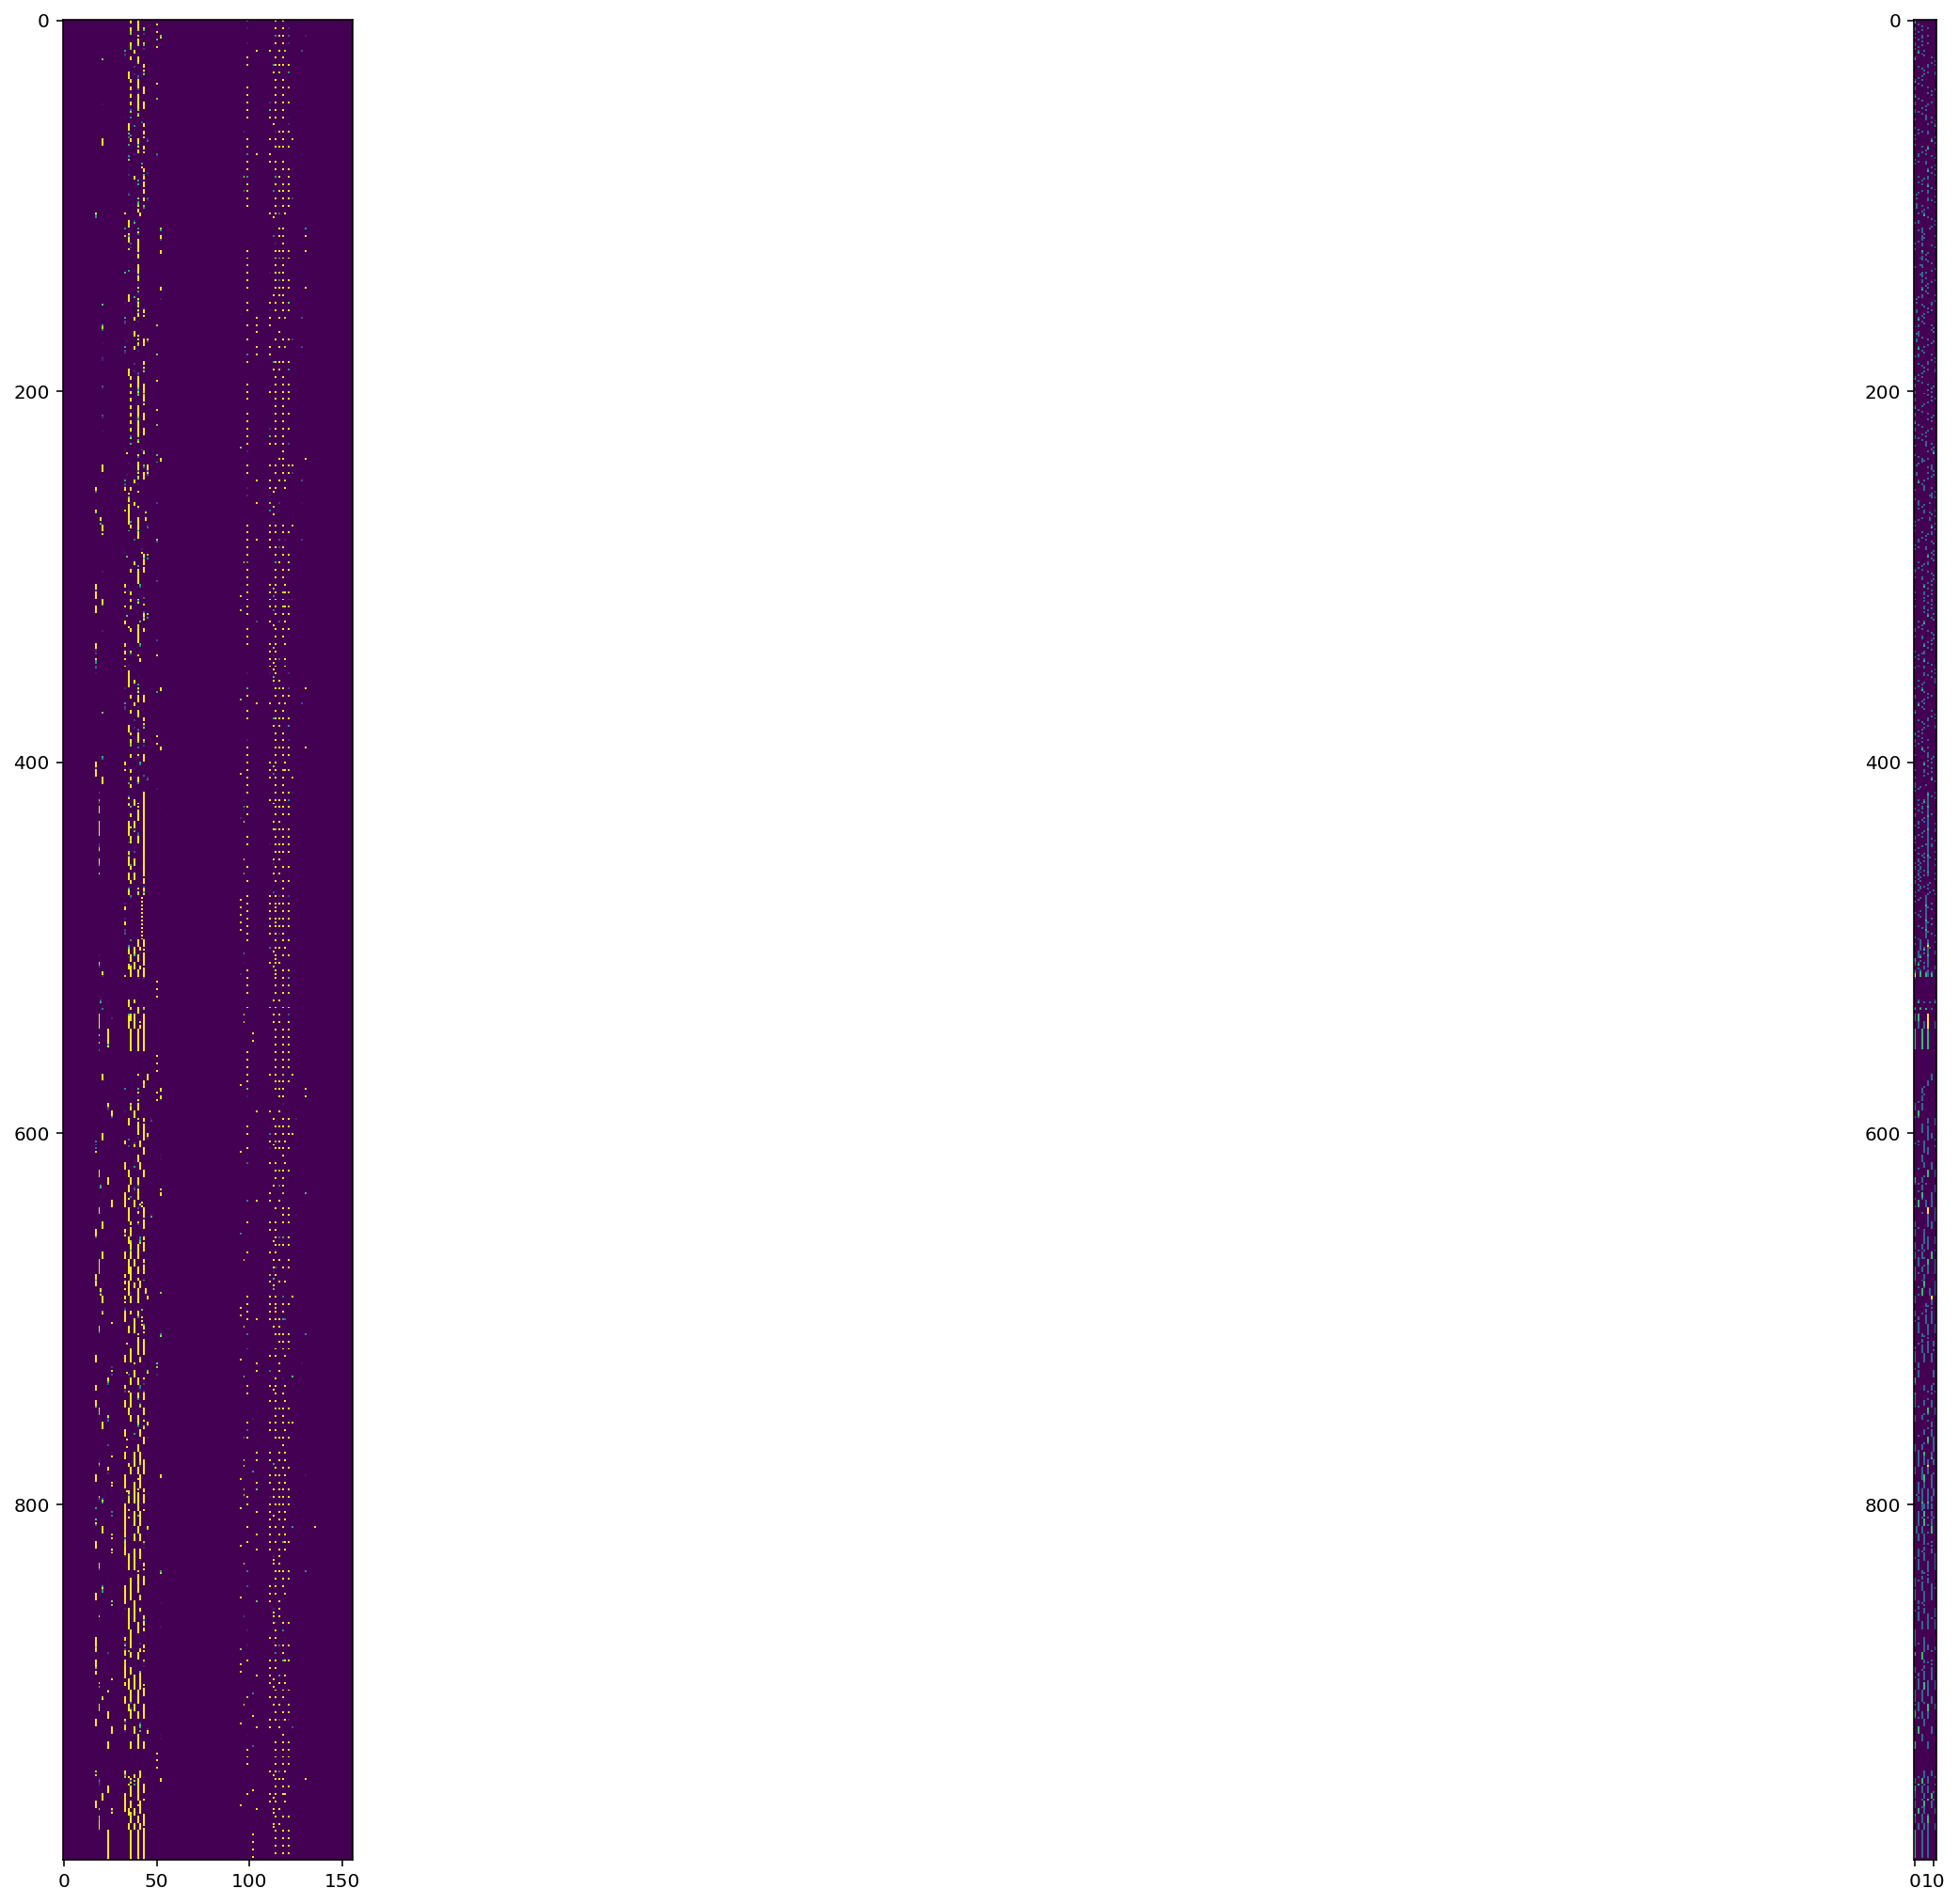

992
0.0
2 (675, 12)
(168, 48) (6, 624)
24
(672, 156) (672, 12)


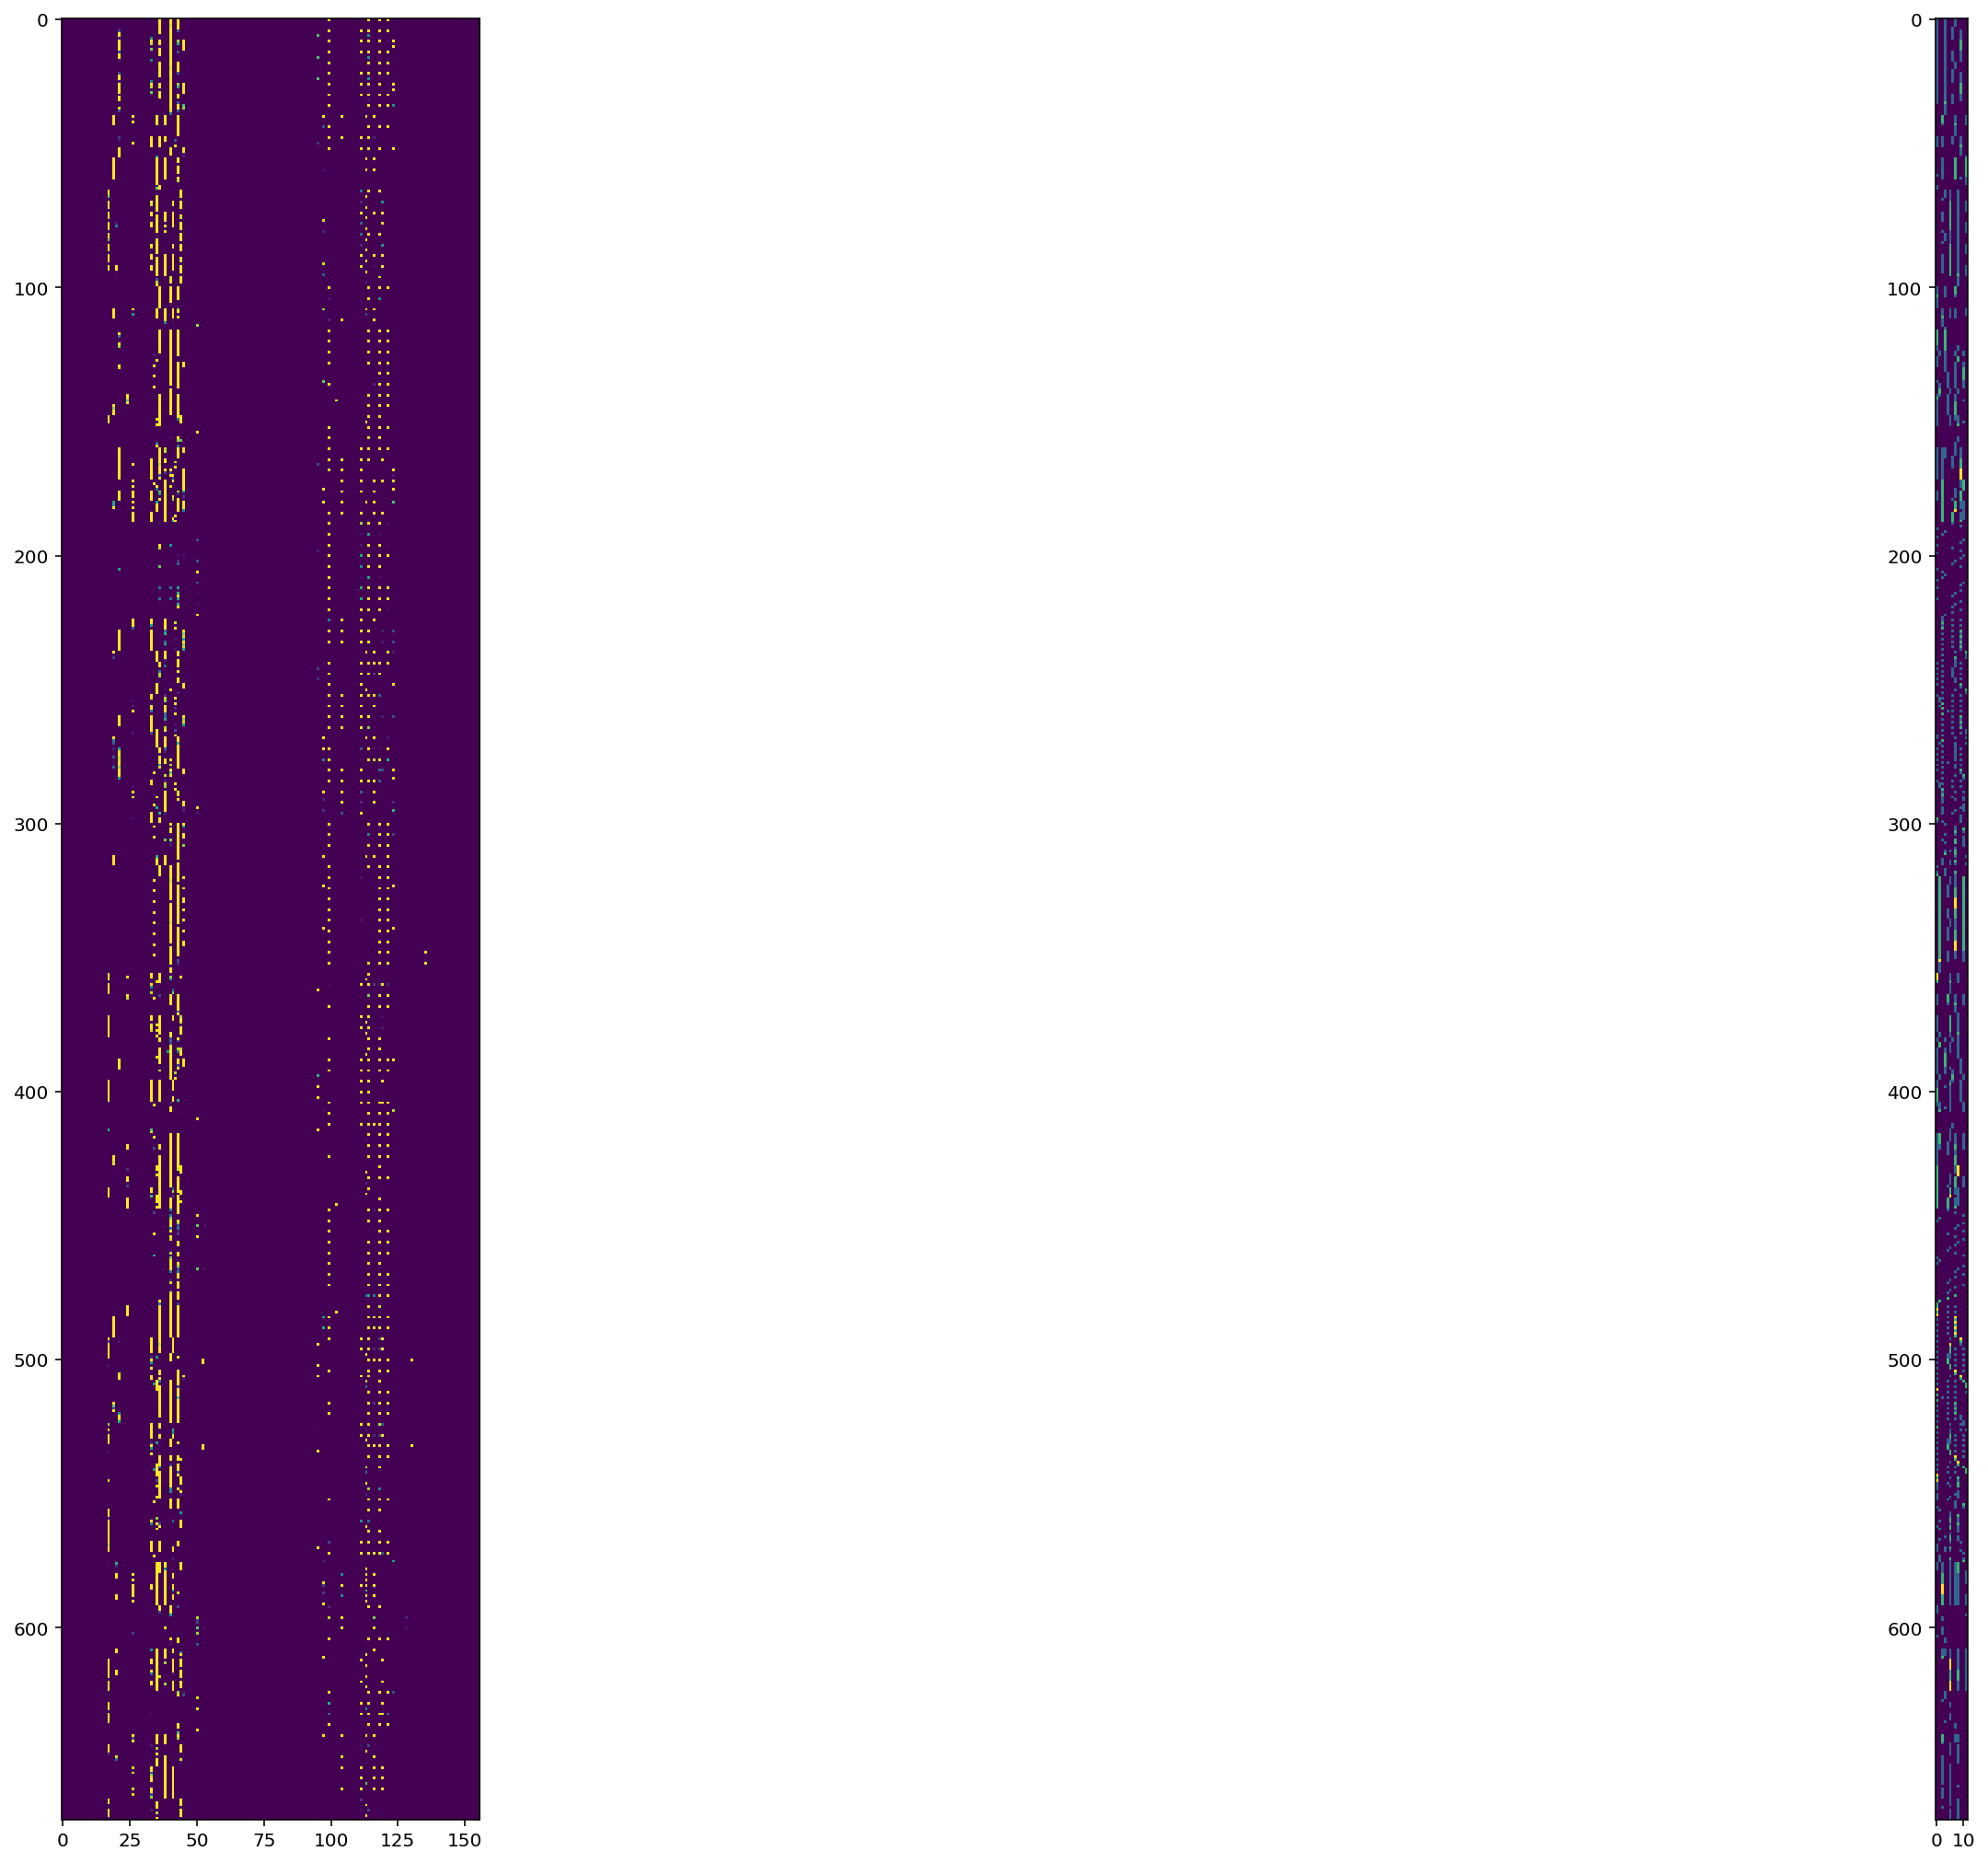

672
0.0
3 (1792, 12)
(448, 48) (6, 624)
24
(1792, 156) (1792, 12)


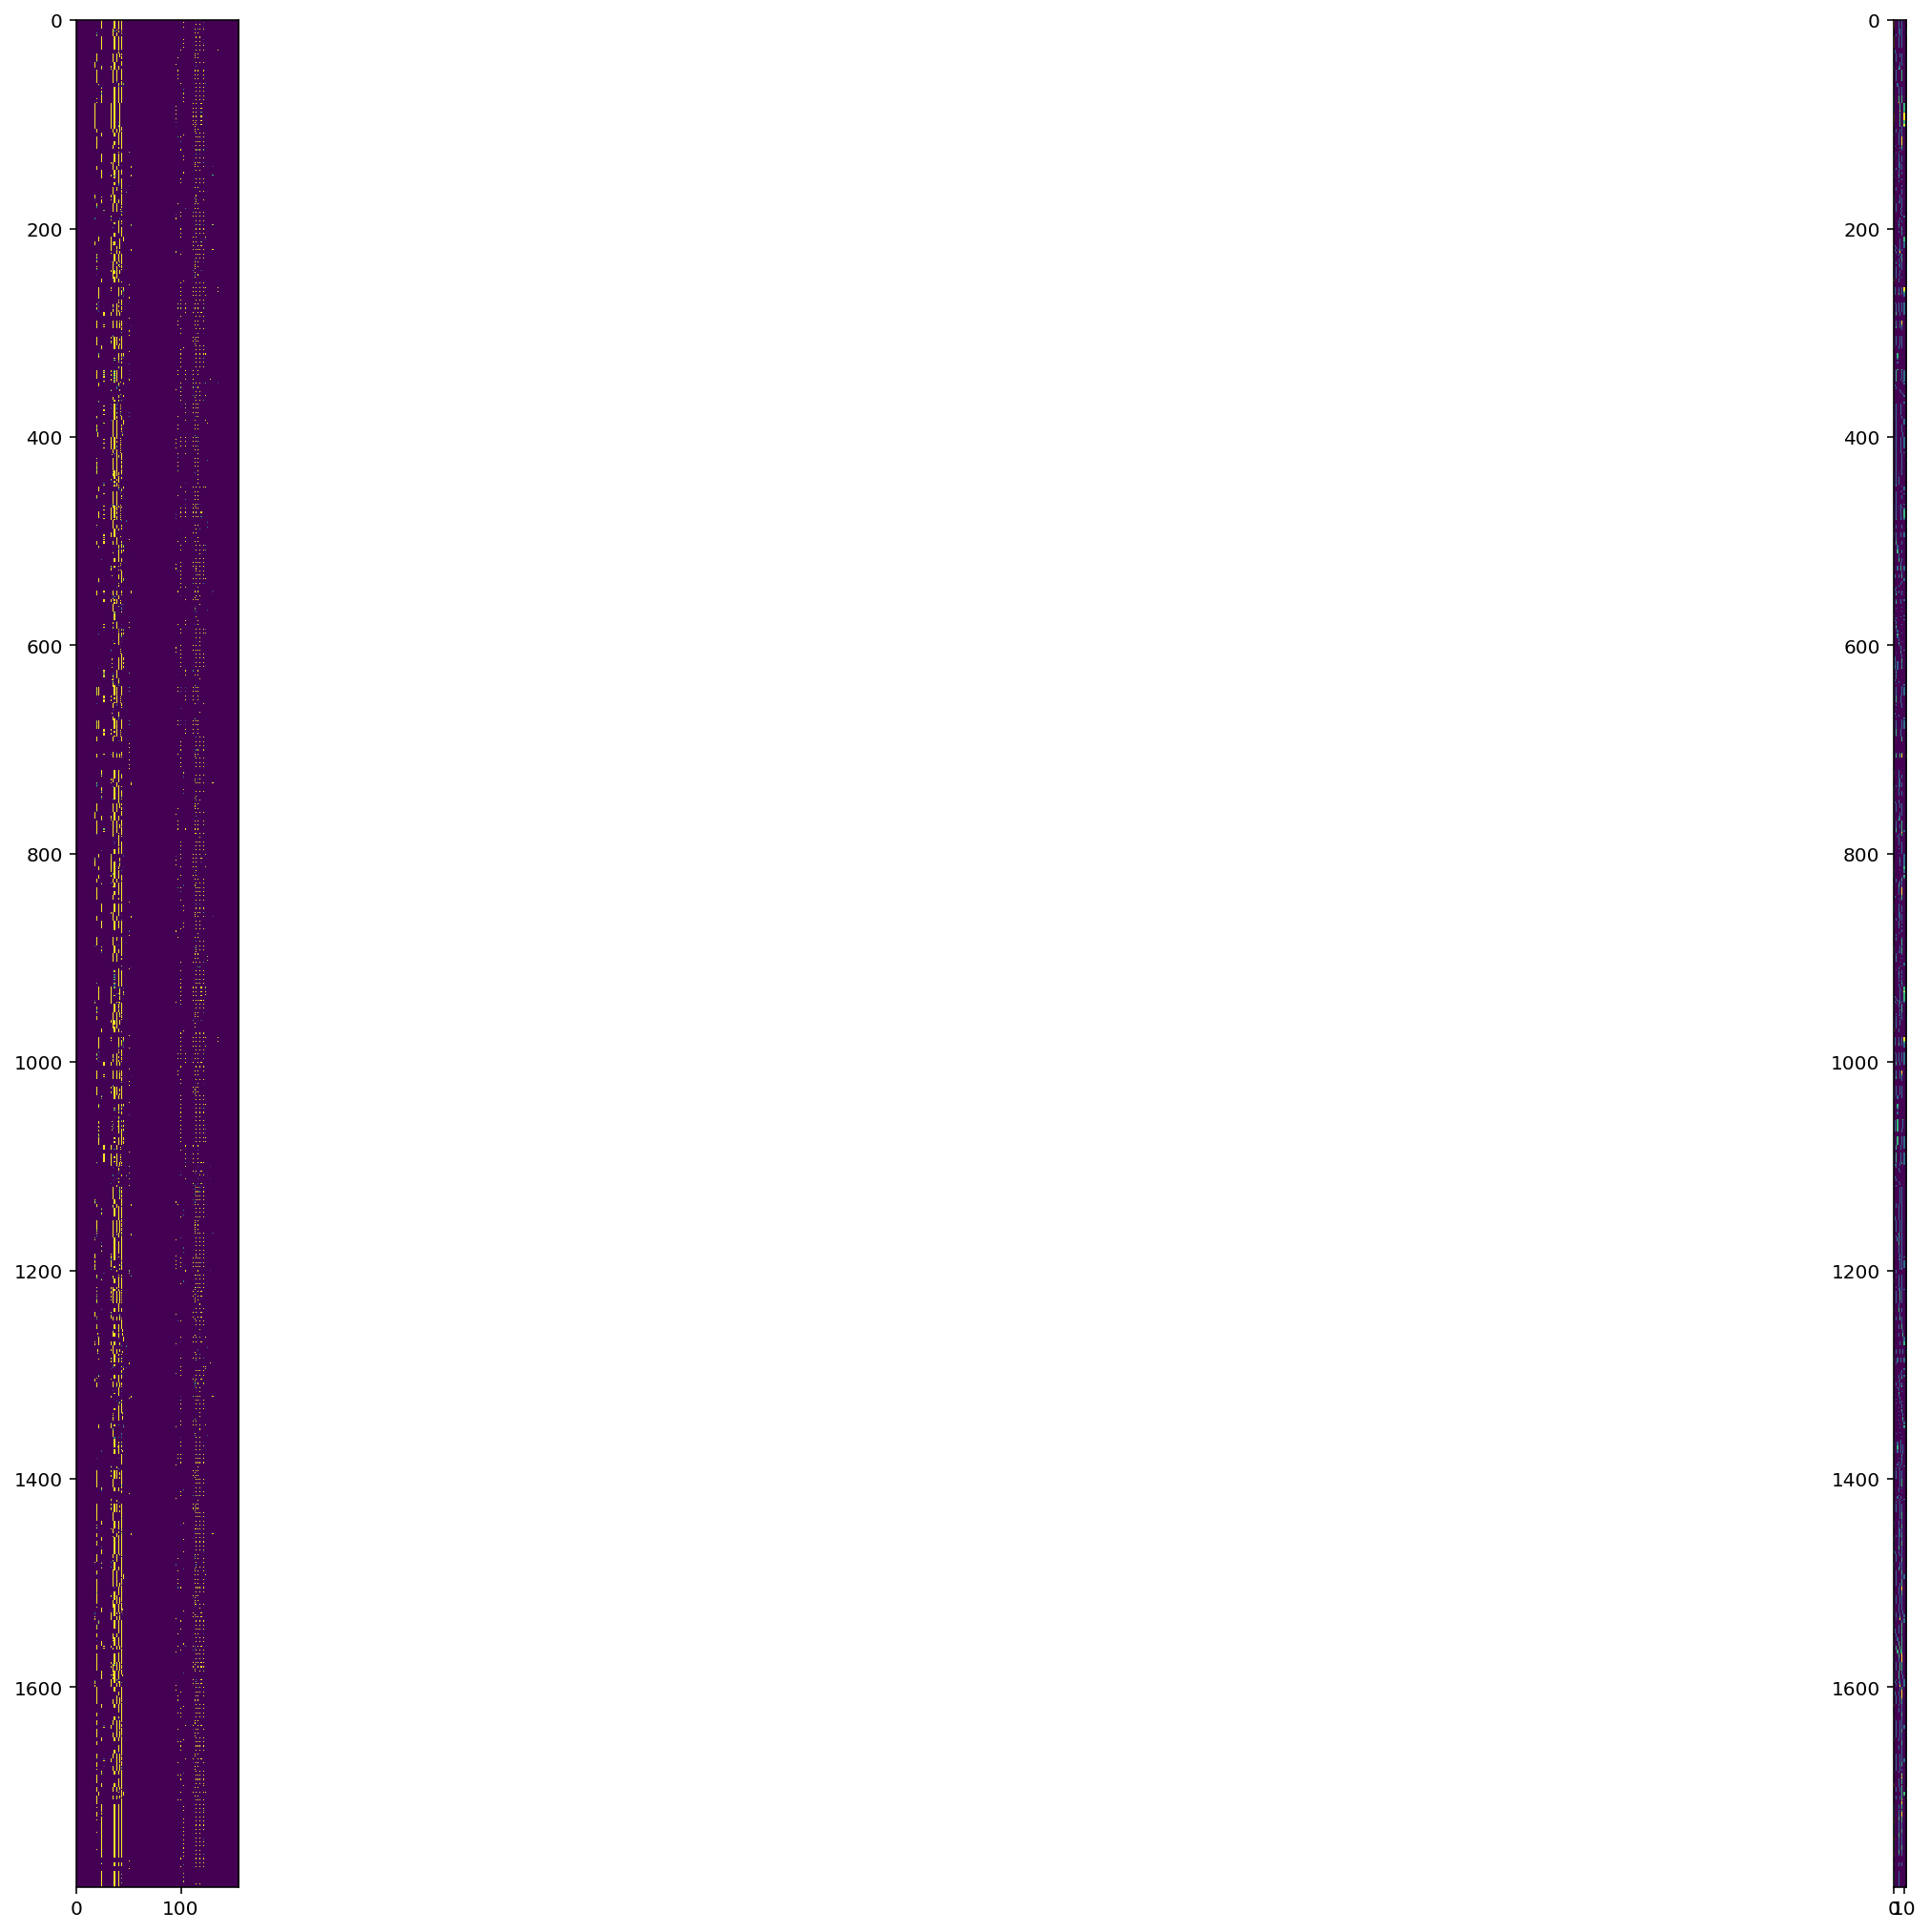

1792
0.0
4 (4277, 12)
(1069, 48) (6, 624)
24
(4276, 156) (4276, 12)


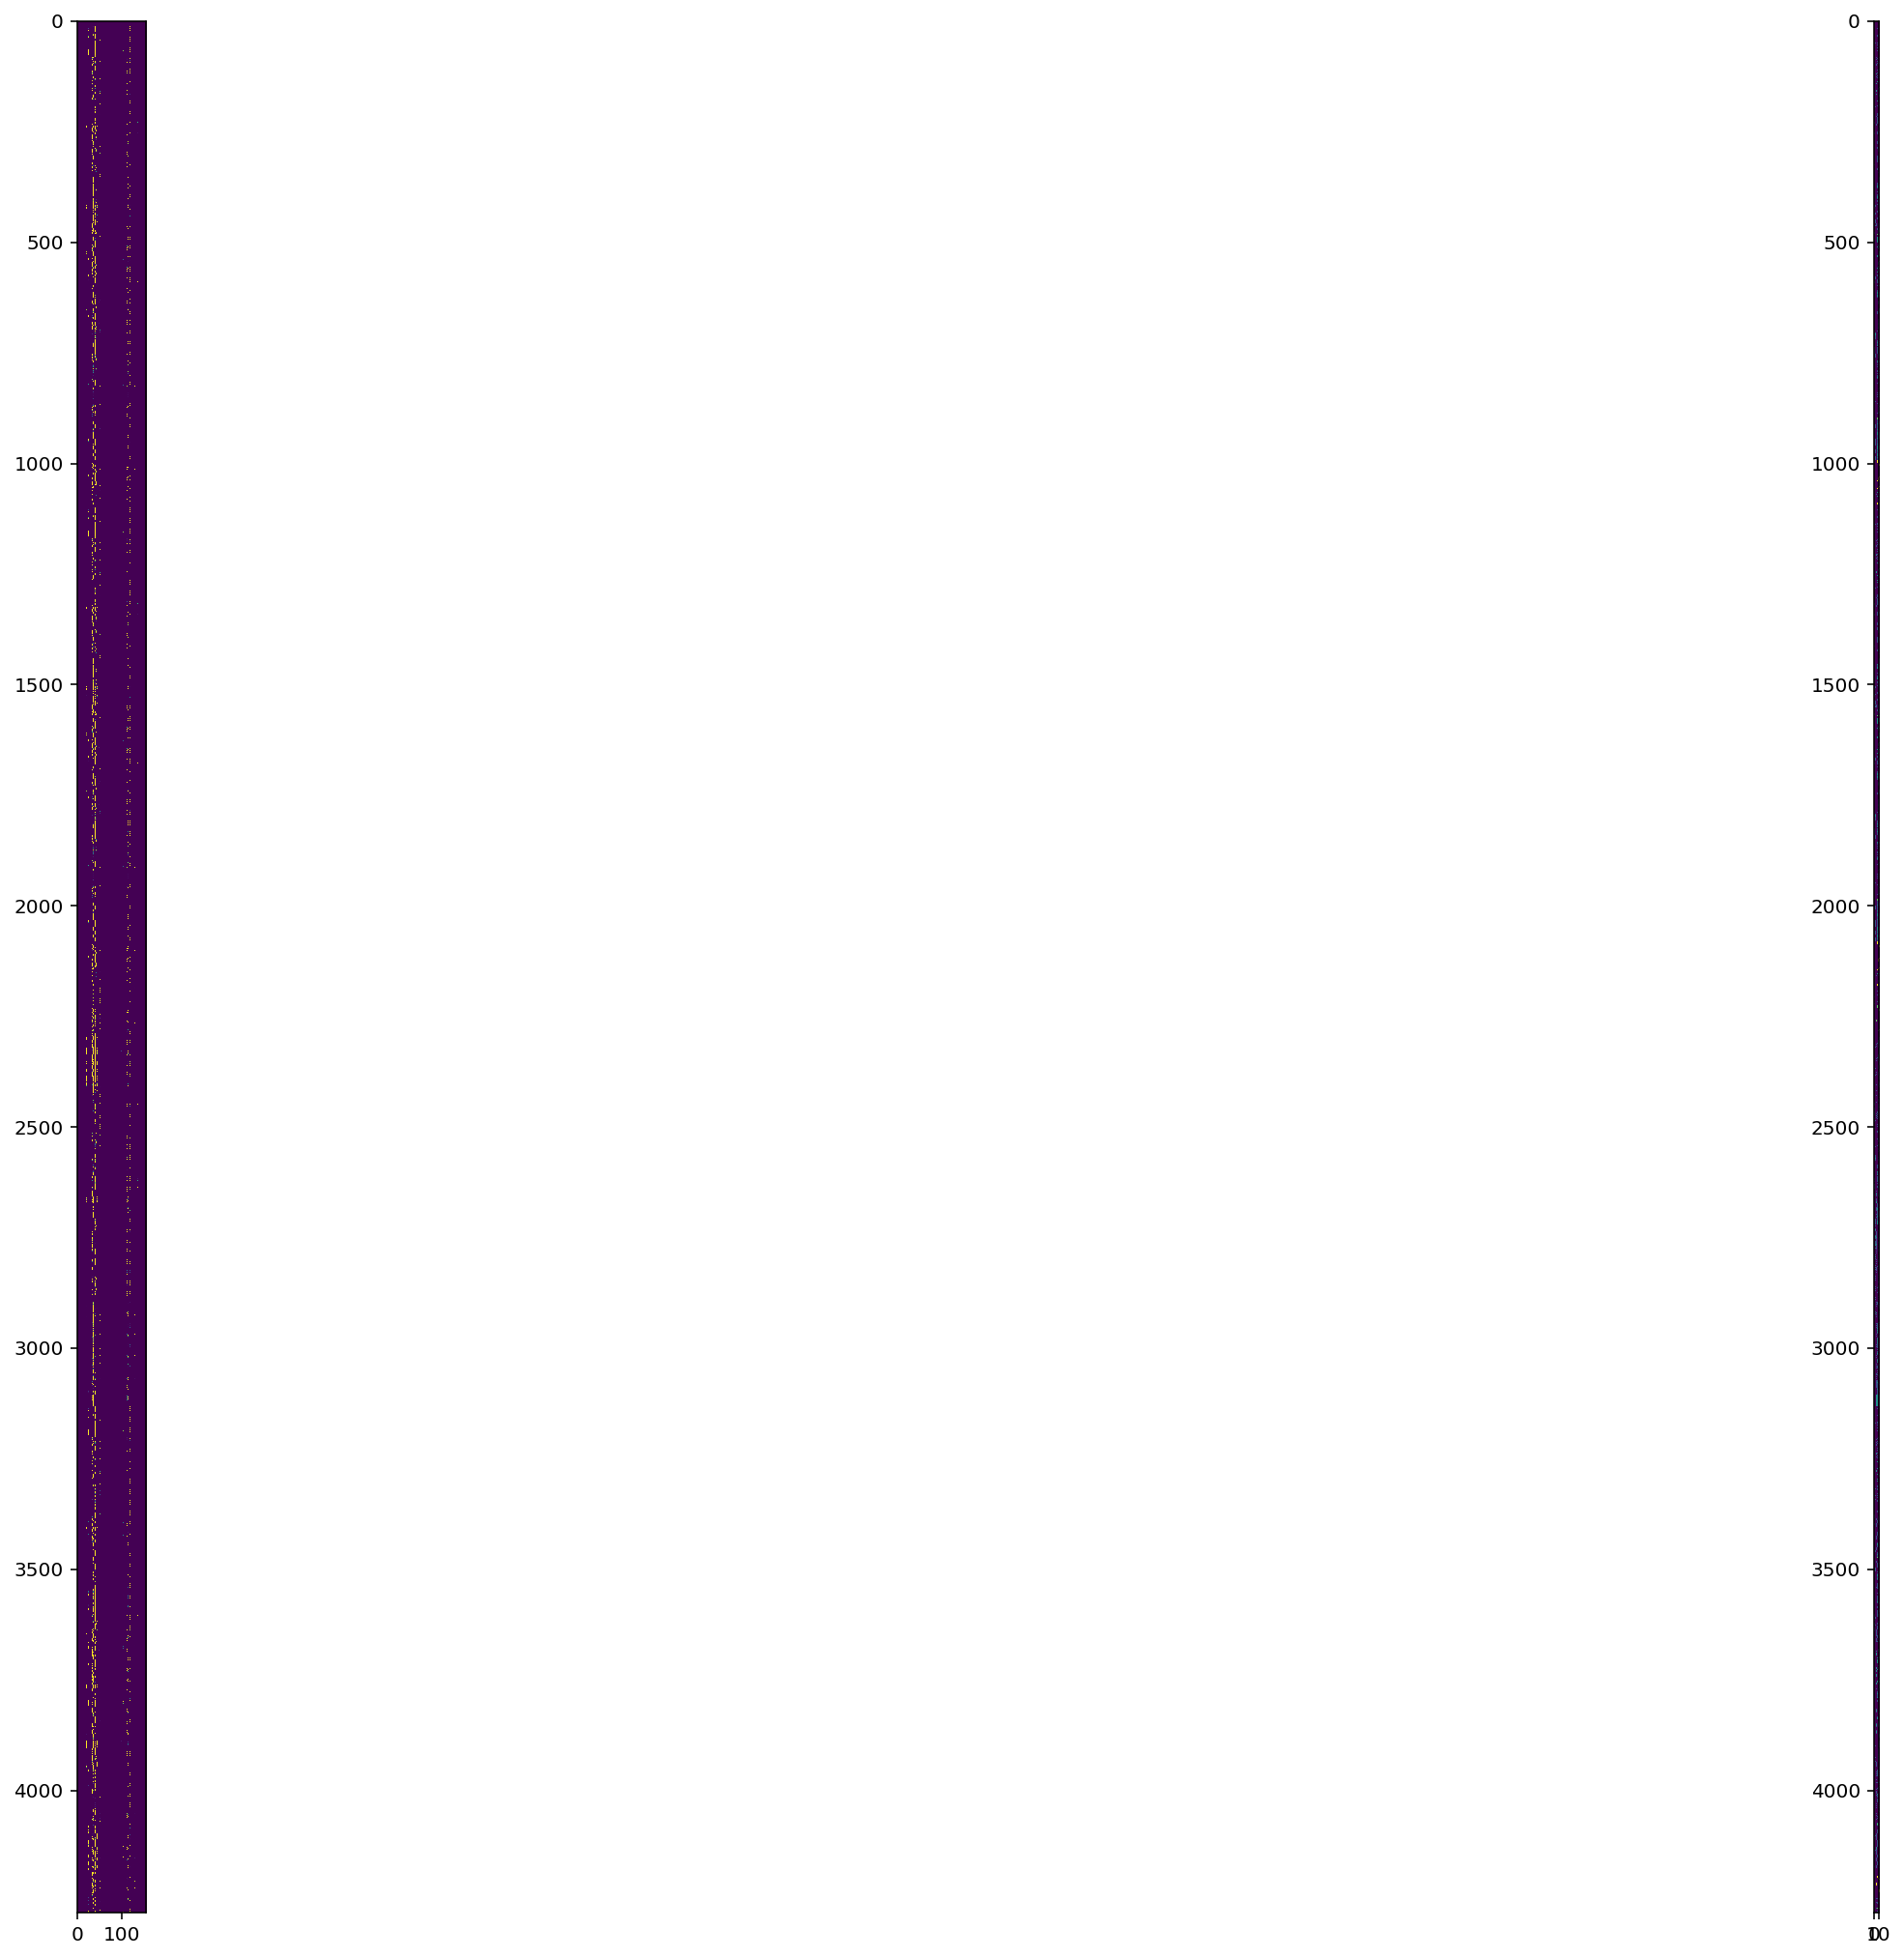

4276
0.0
5 (2802, 12)
(700, 48) (6, 624)
24
(2800, 156) (2800, 12)


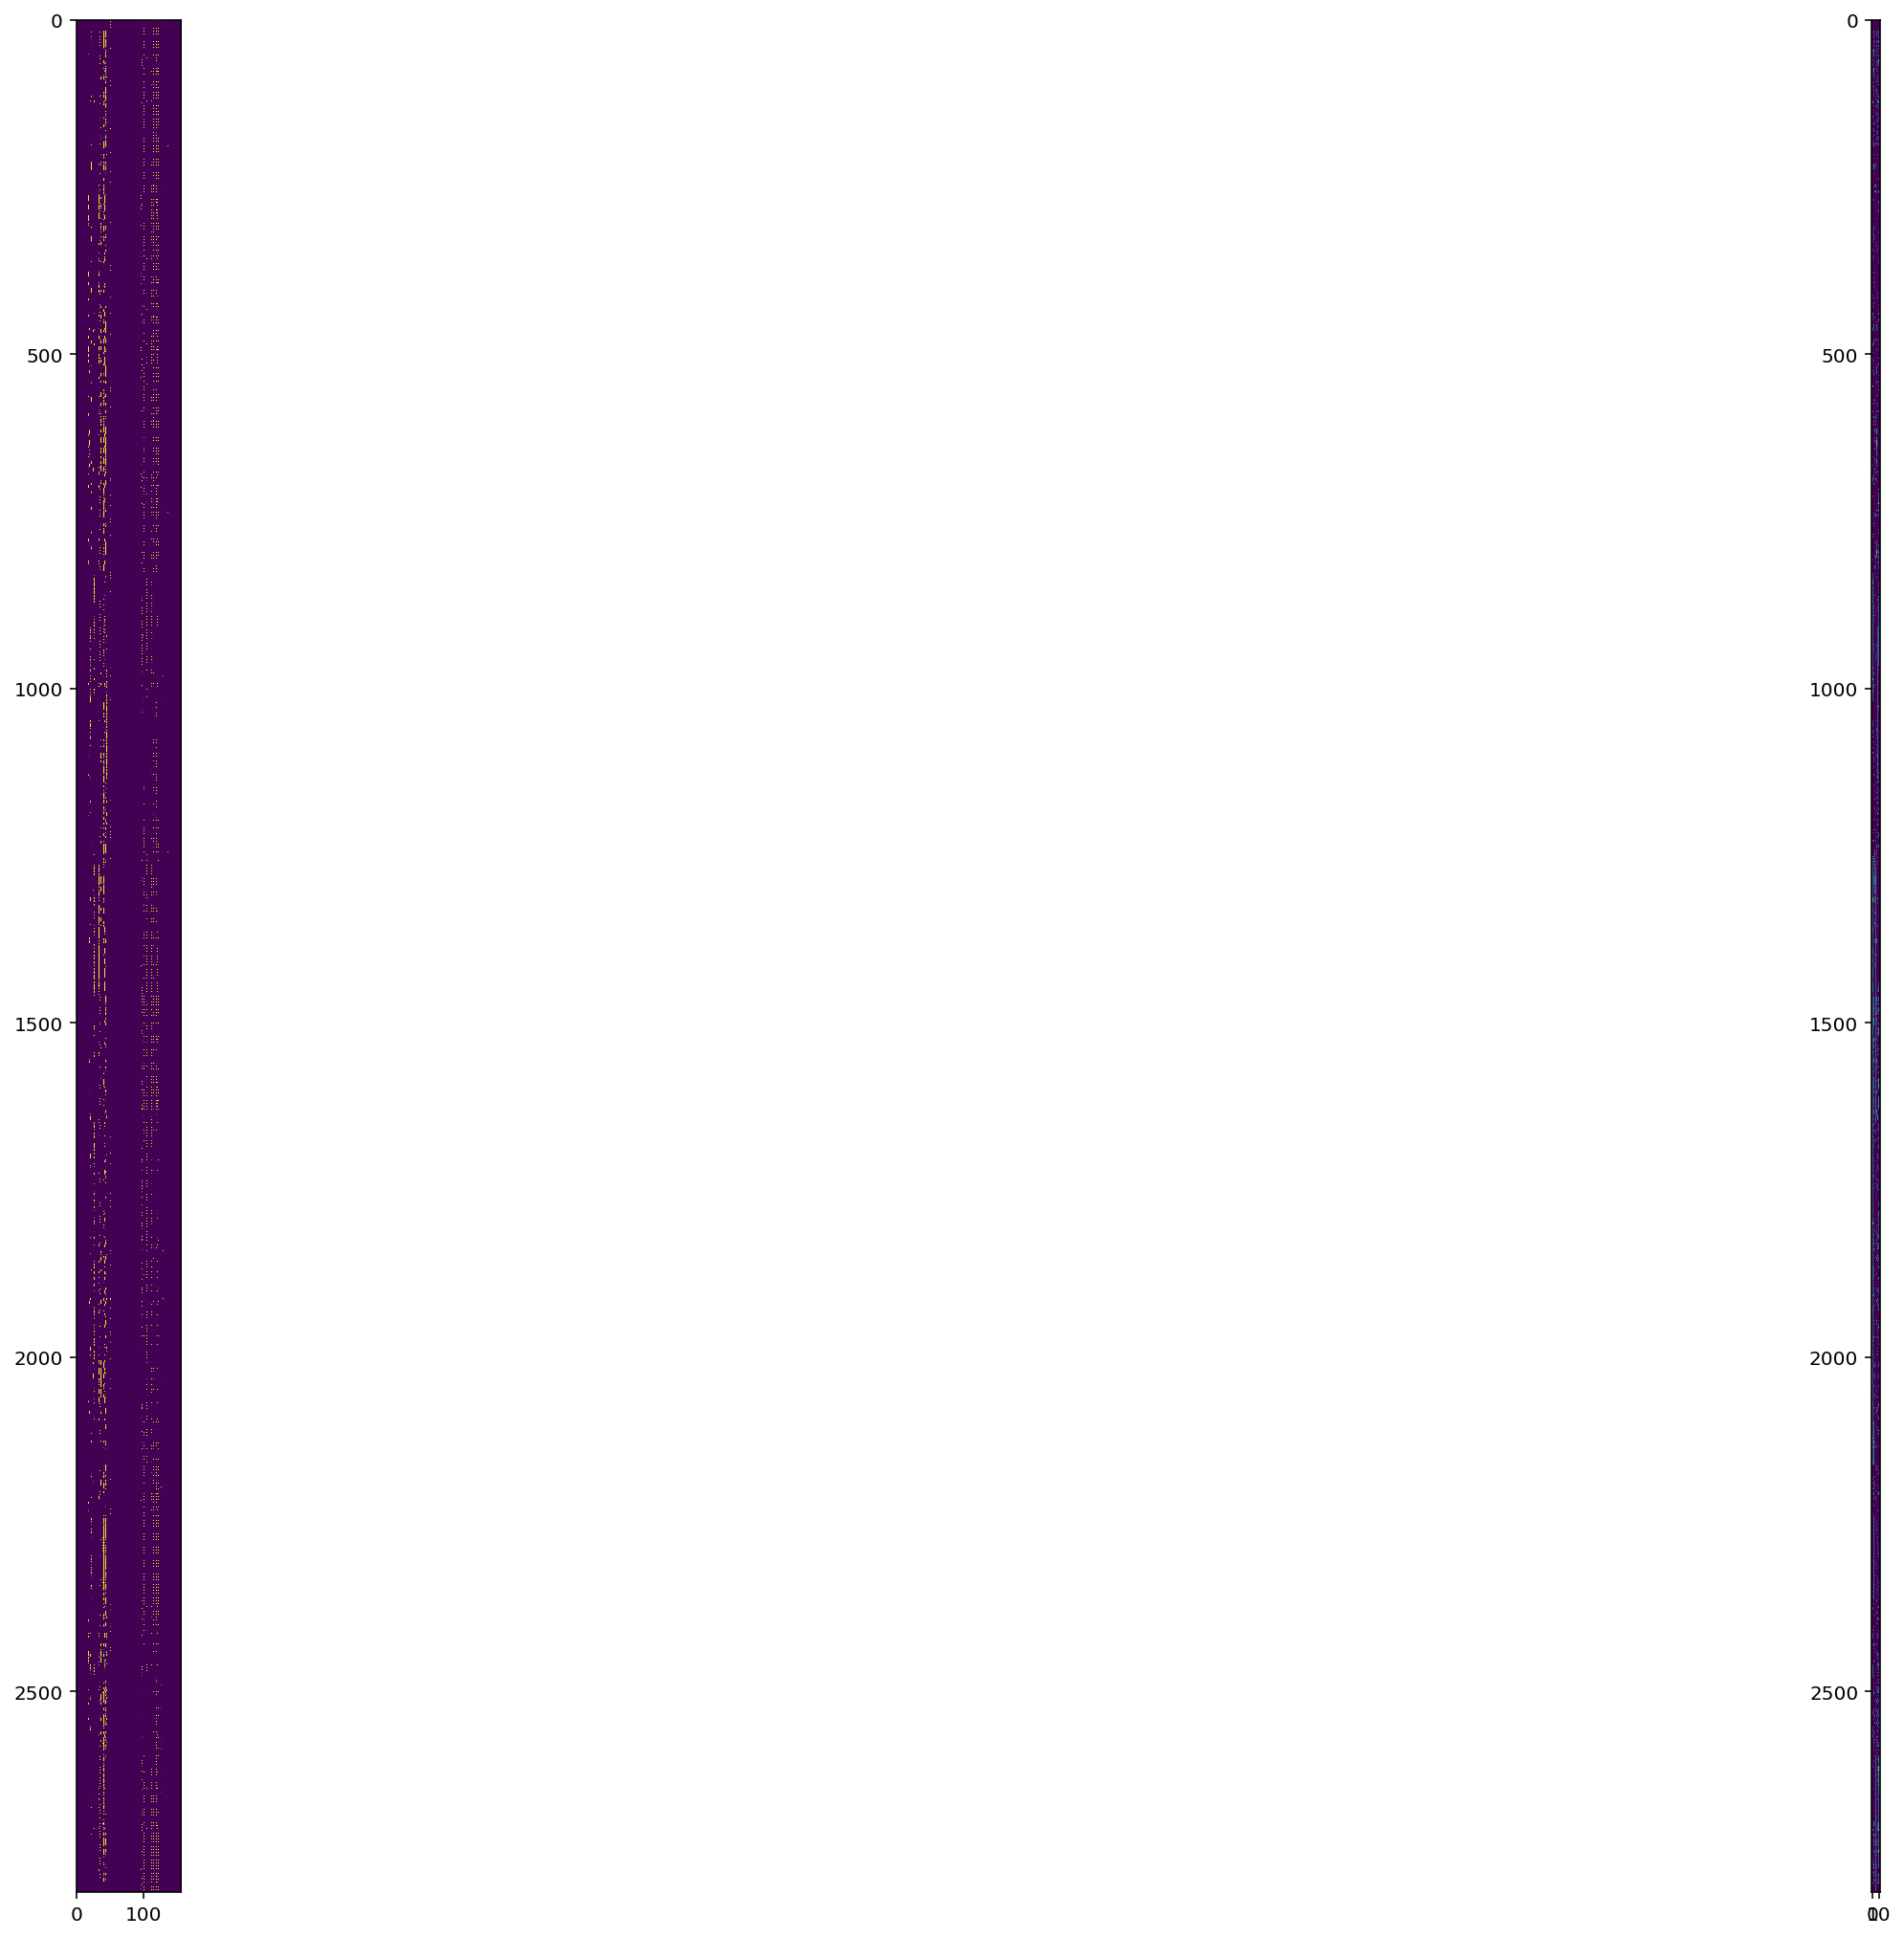

2800
0.0
6 (1088, 12)
(272, 48) (6, 624)
24
(1088, 156) (1088, 12)


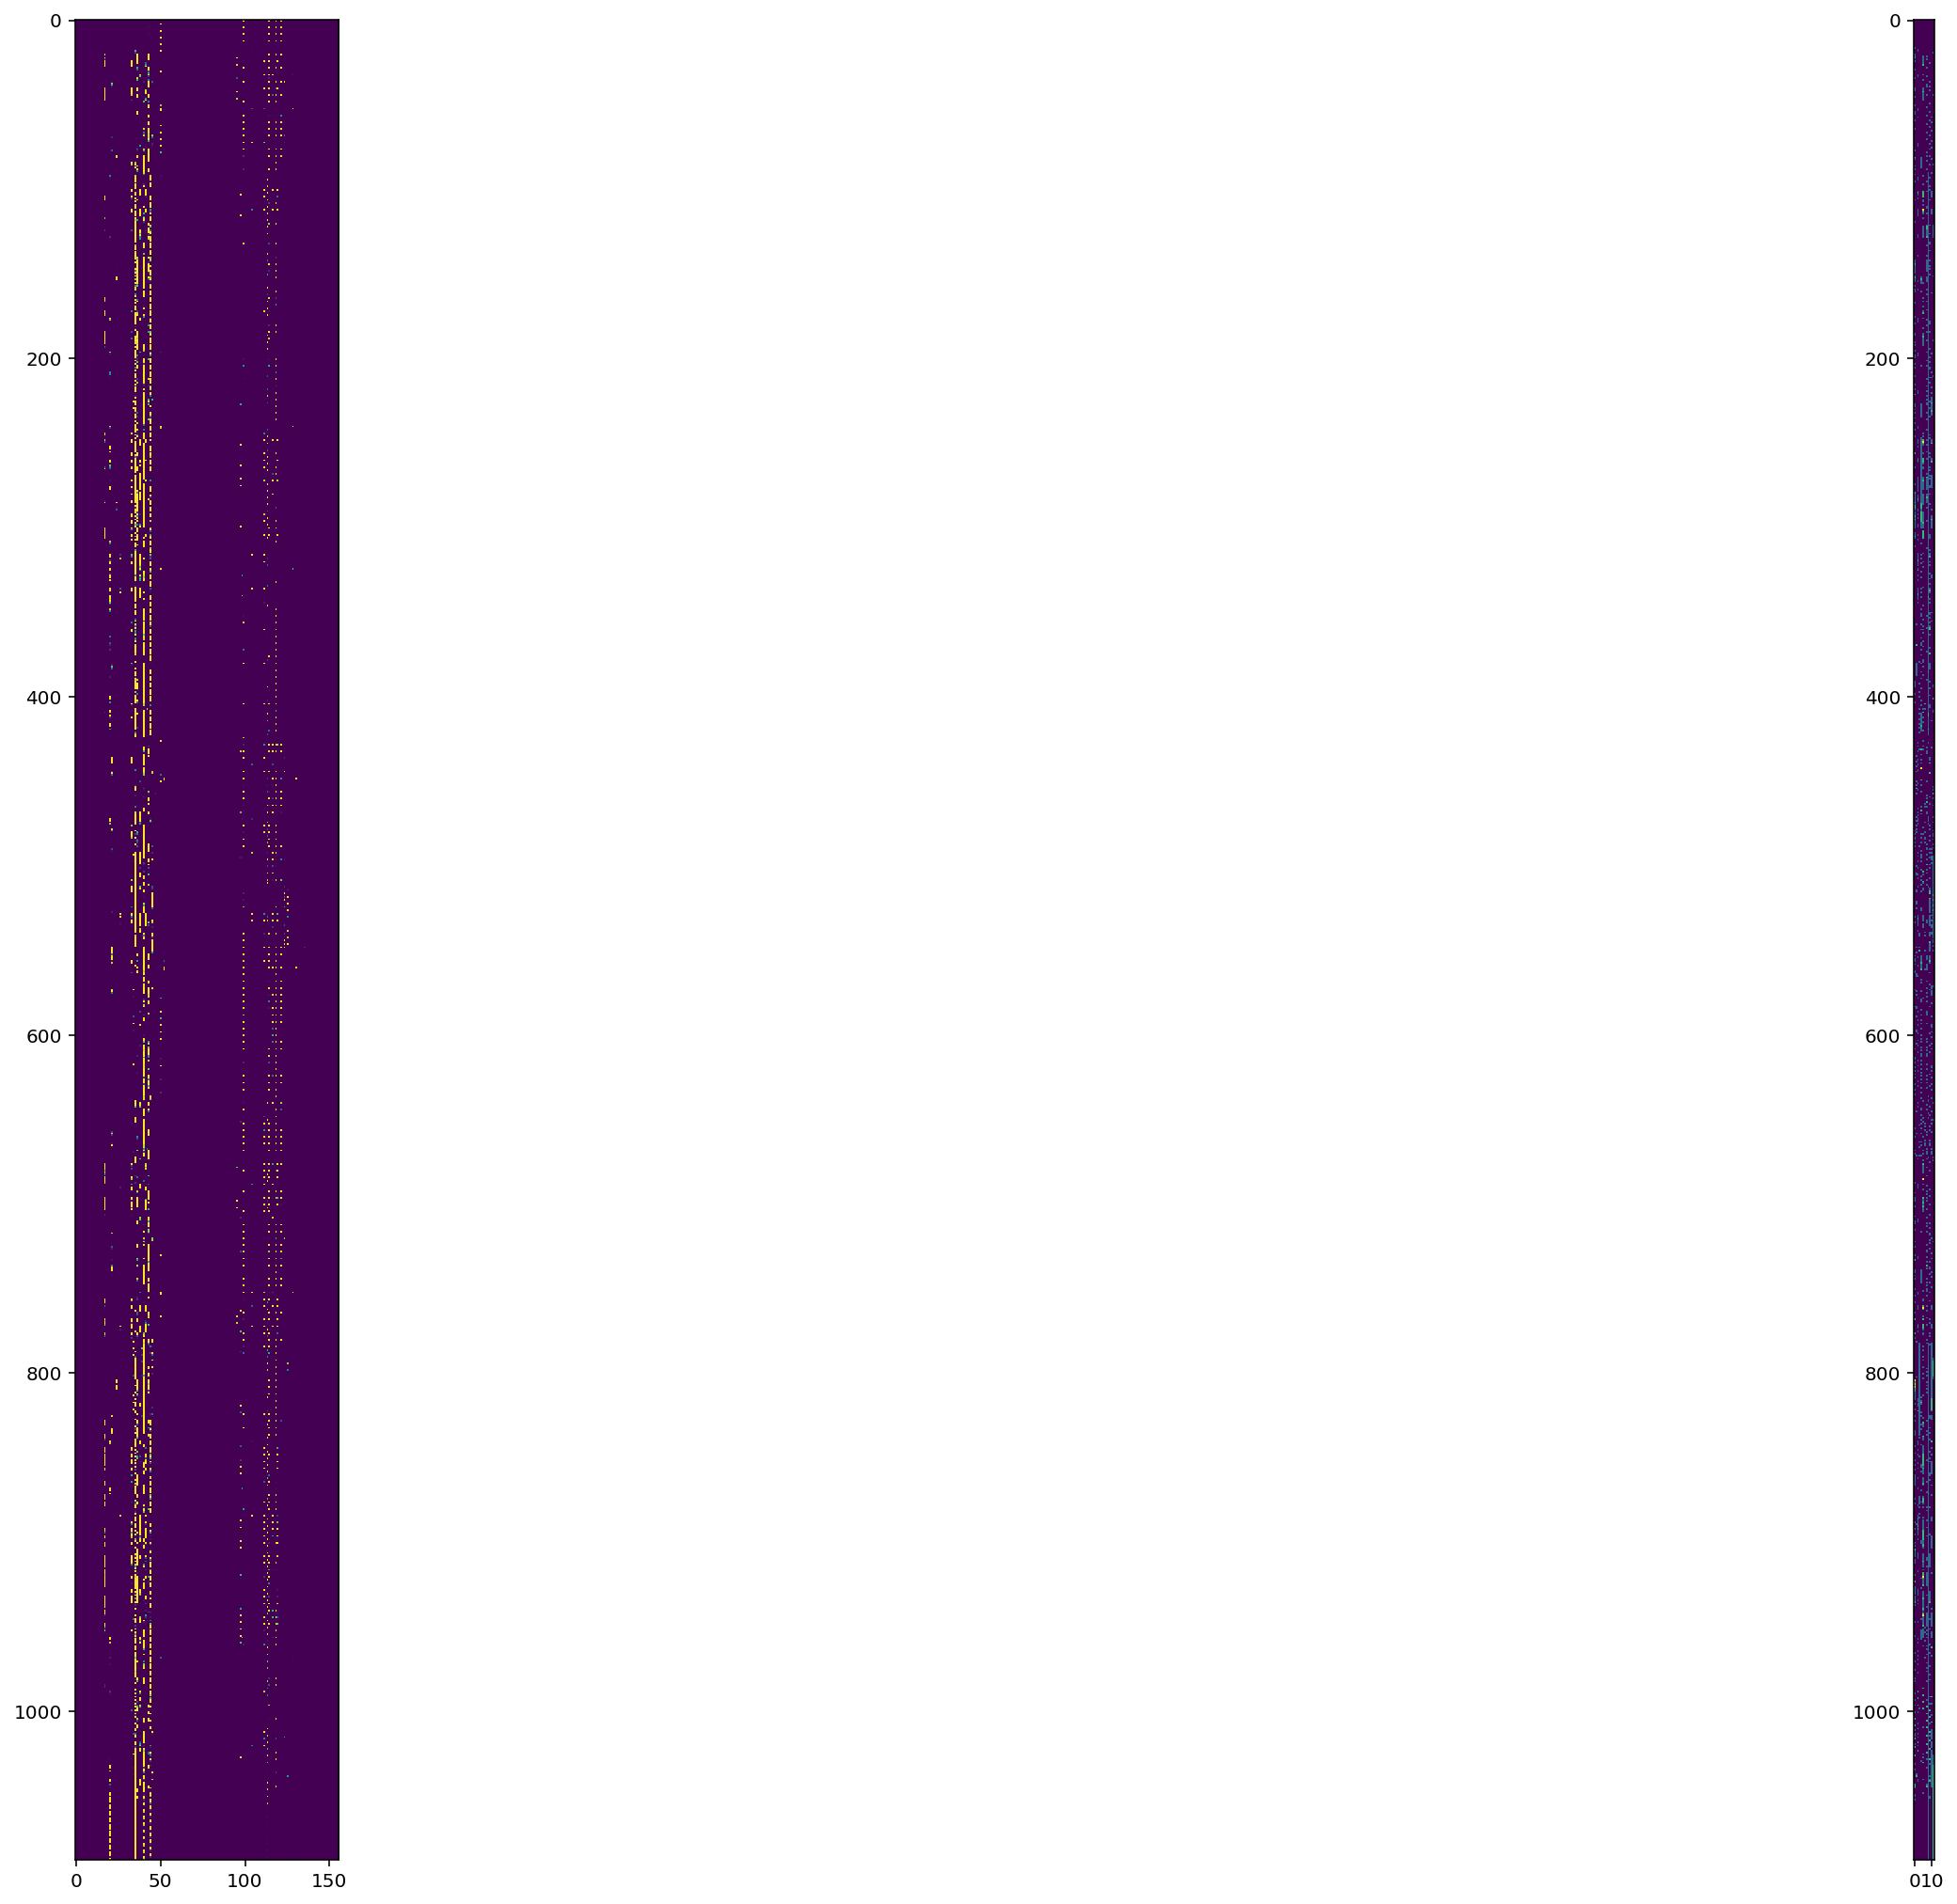

1088
0.0
7 (2105, 12)
(526, 48) (6, 624)
24
(2104, 156) (2104, 12)


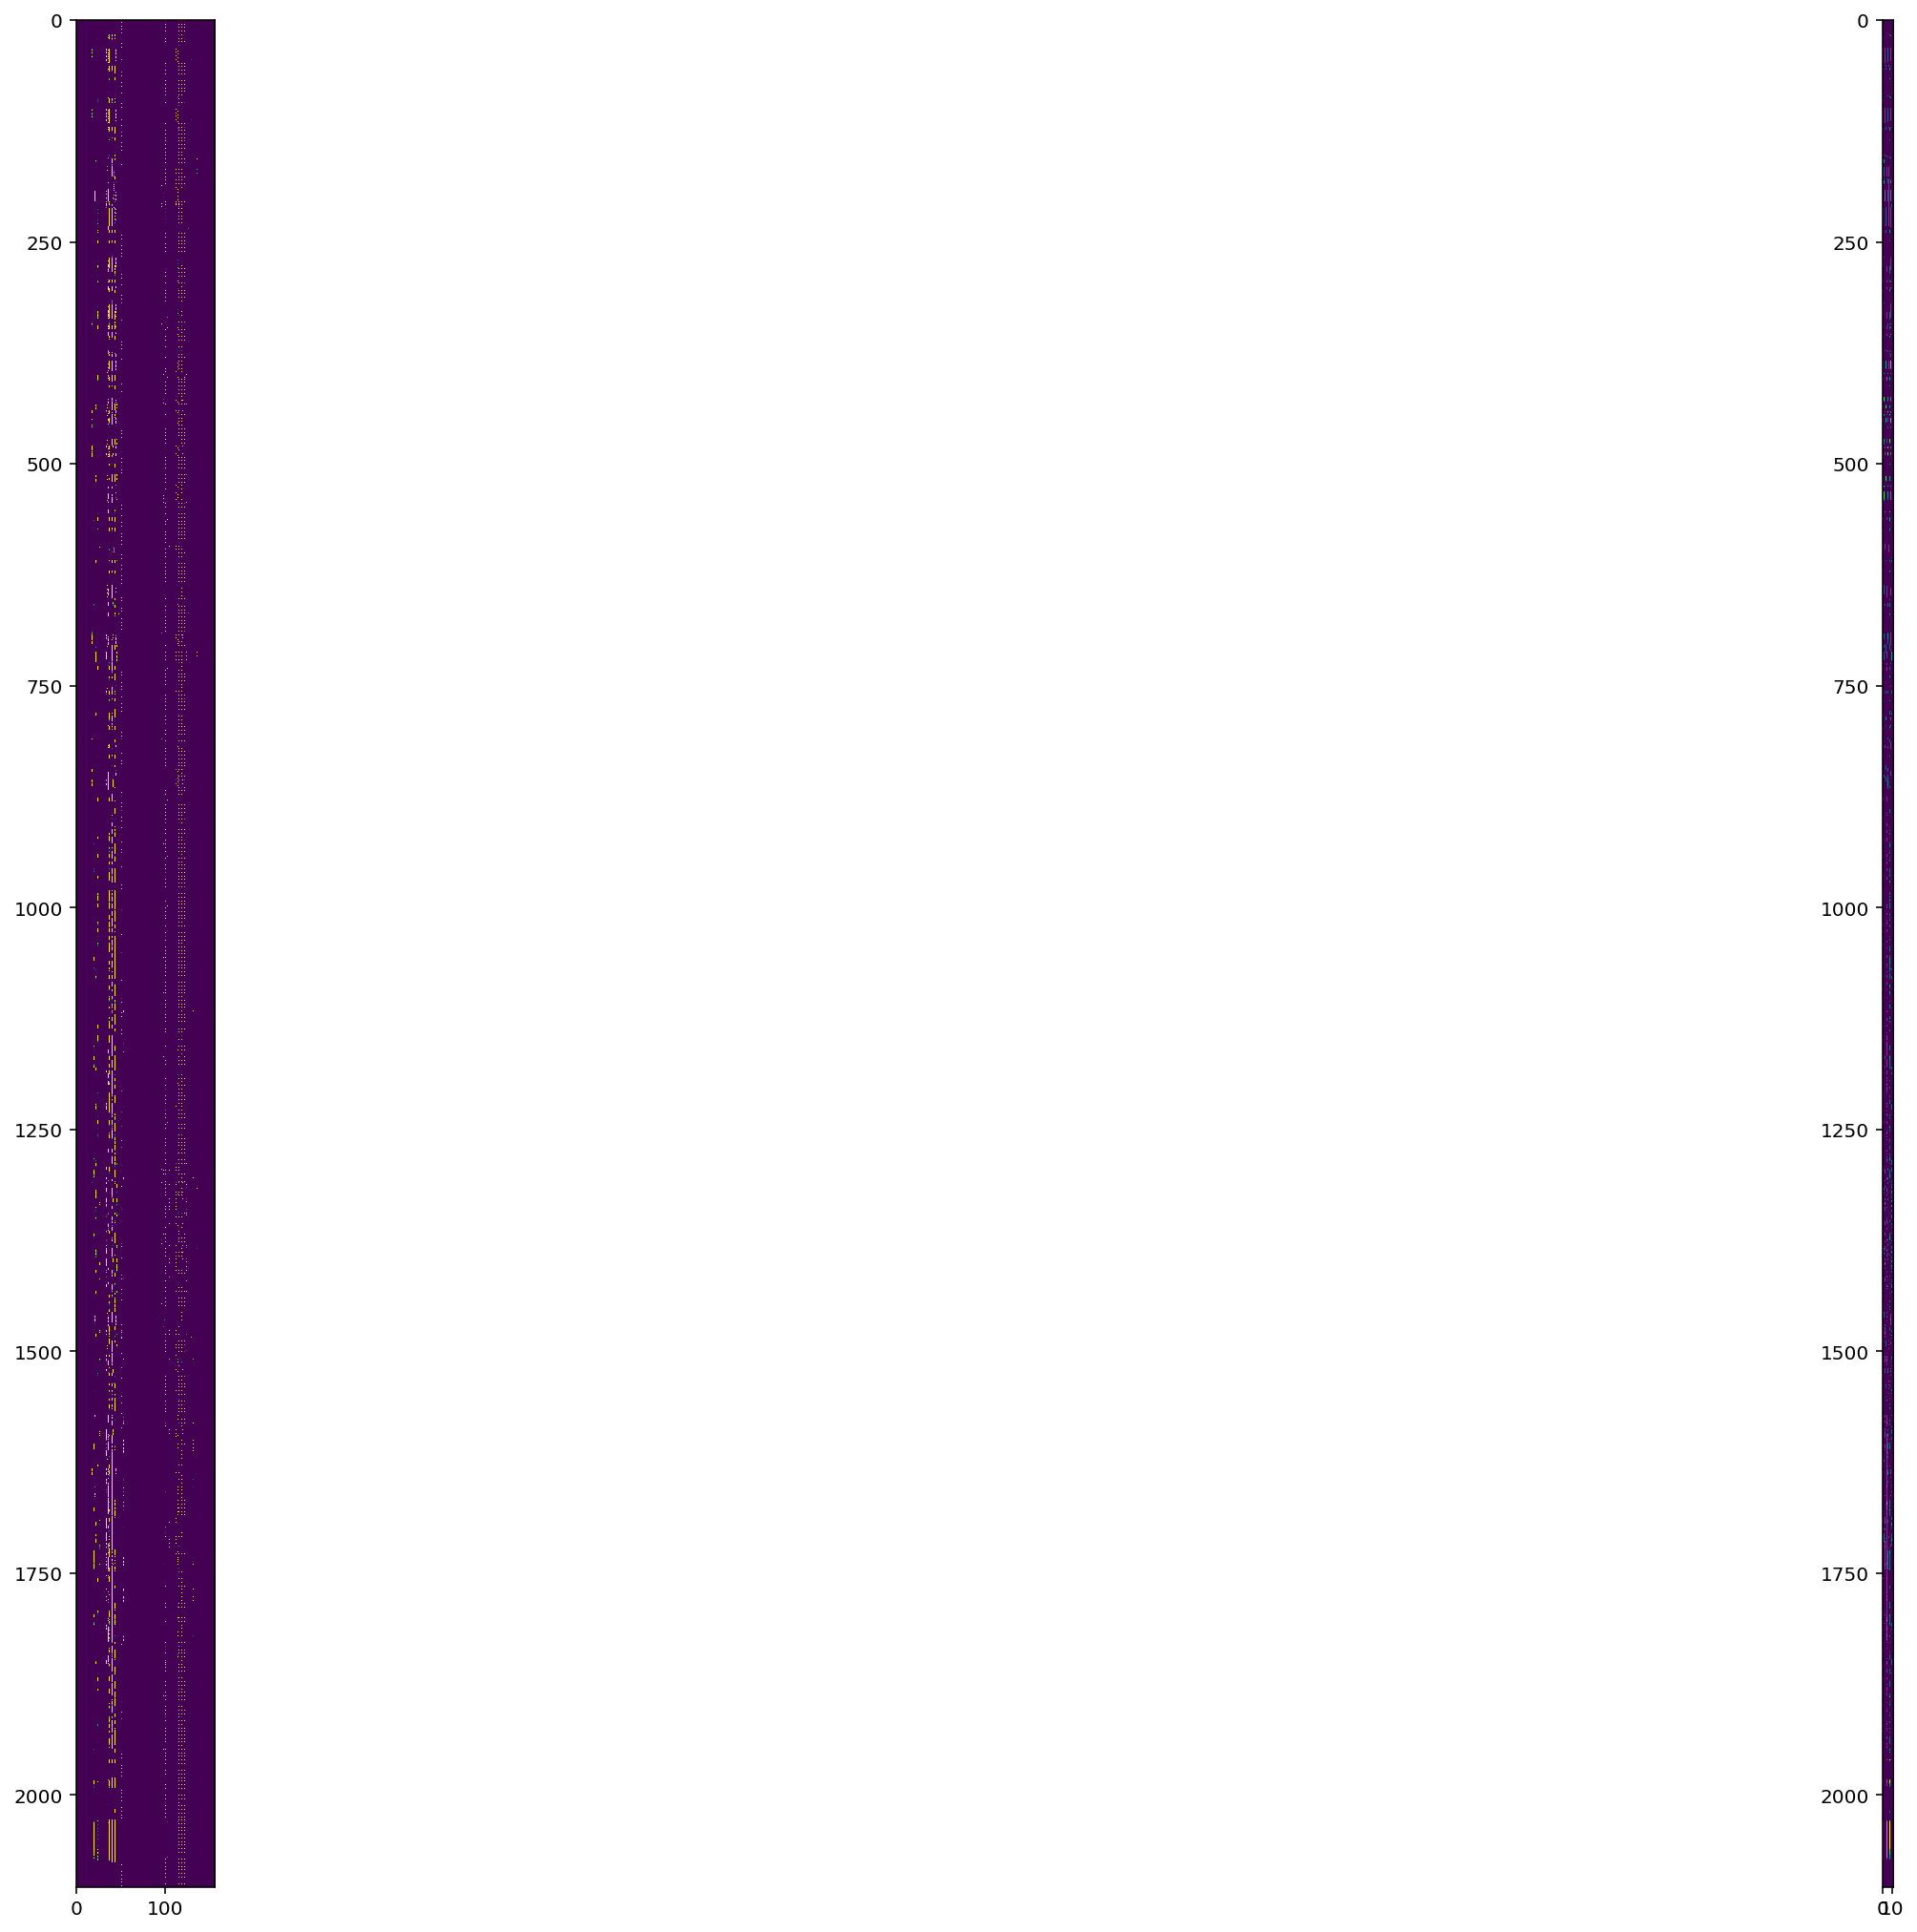

2104
0.0
8 (2391, 12)
(597, 48) (6, 624)
24
(2388, 156) (2388, 12)


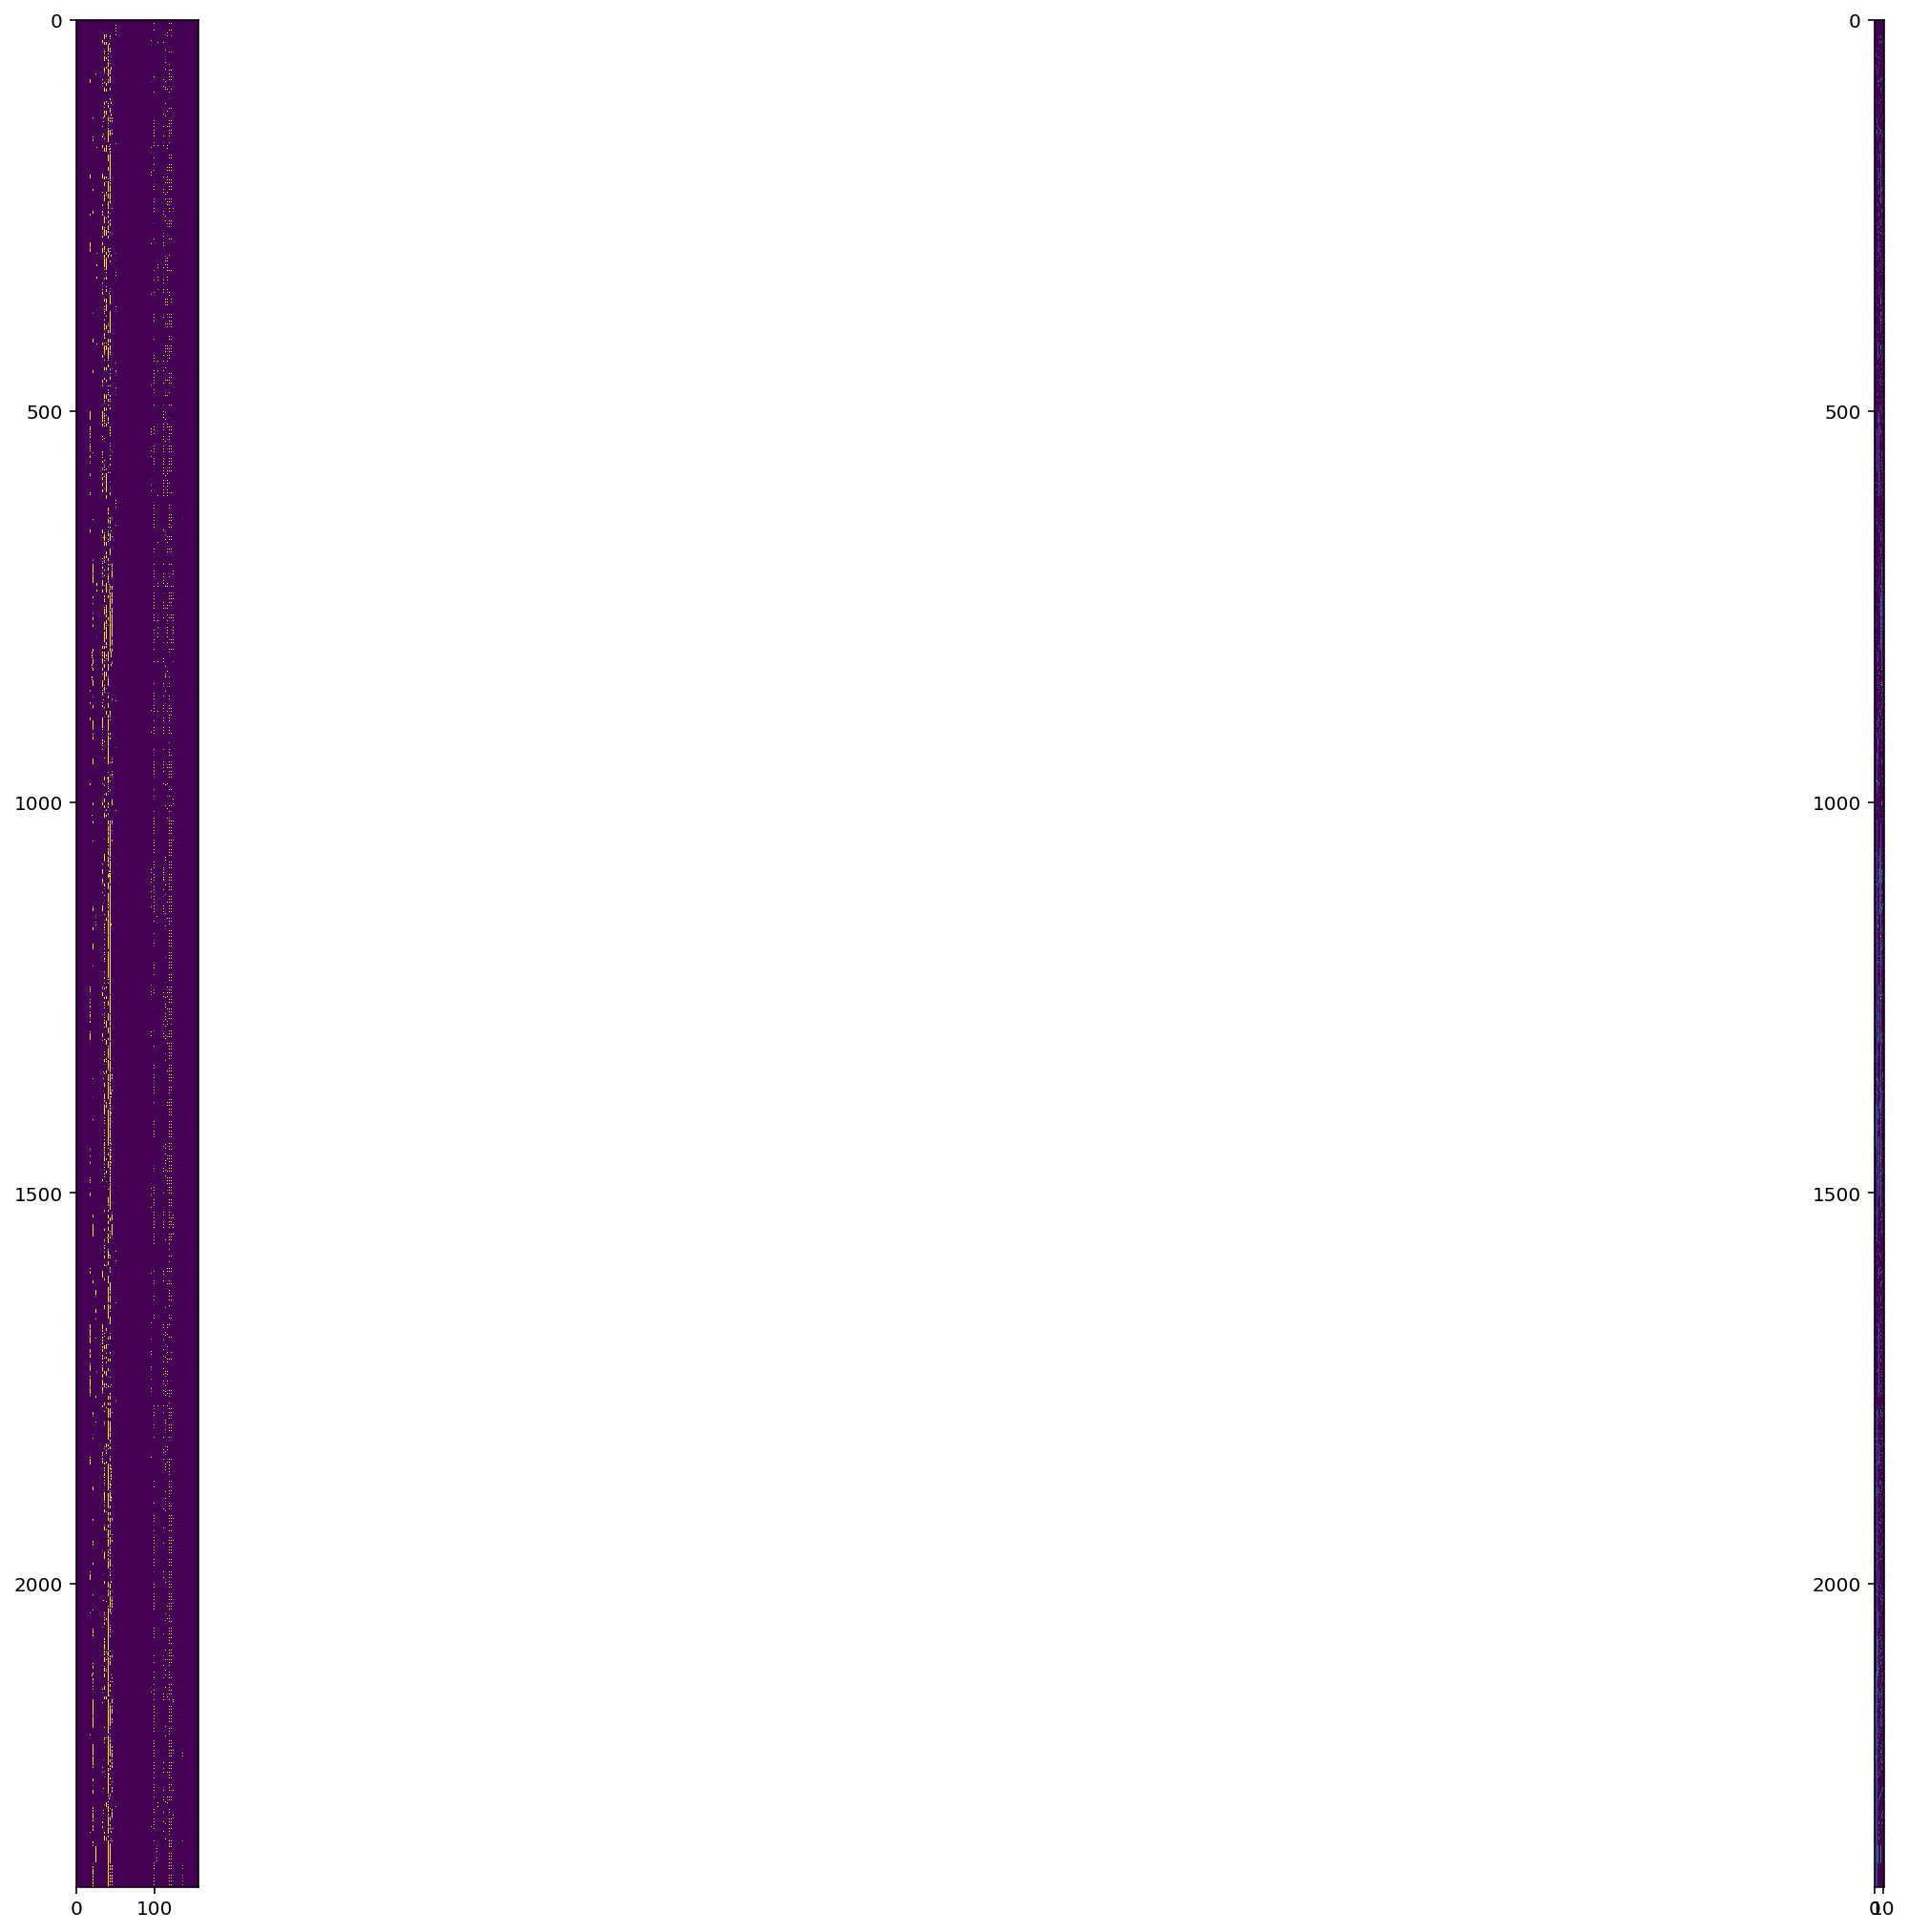

2388
0.0
9 (2943, 12)
(735, 48) (6, 624)
24
(2940, 156) (2940, 12)


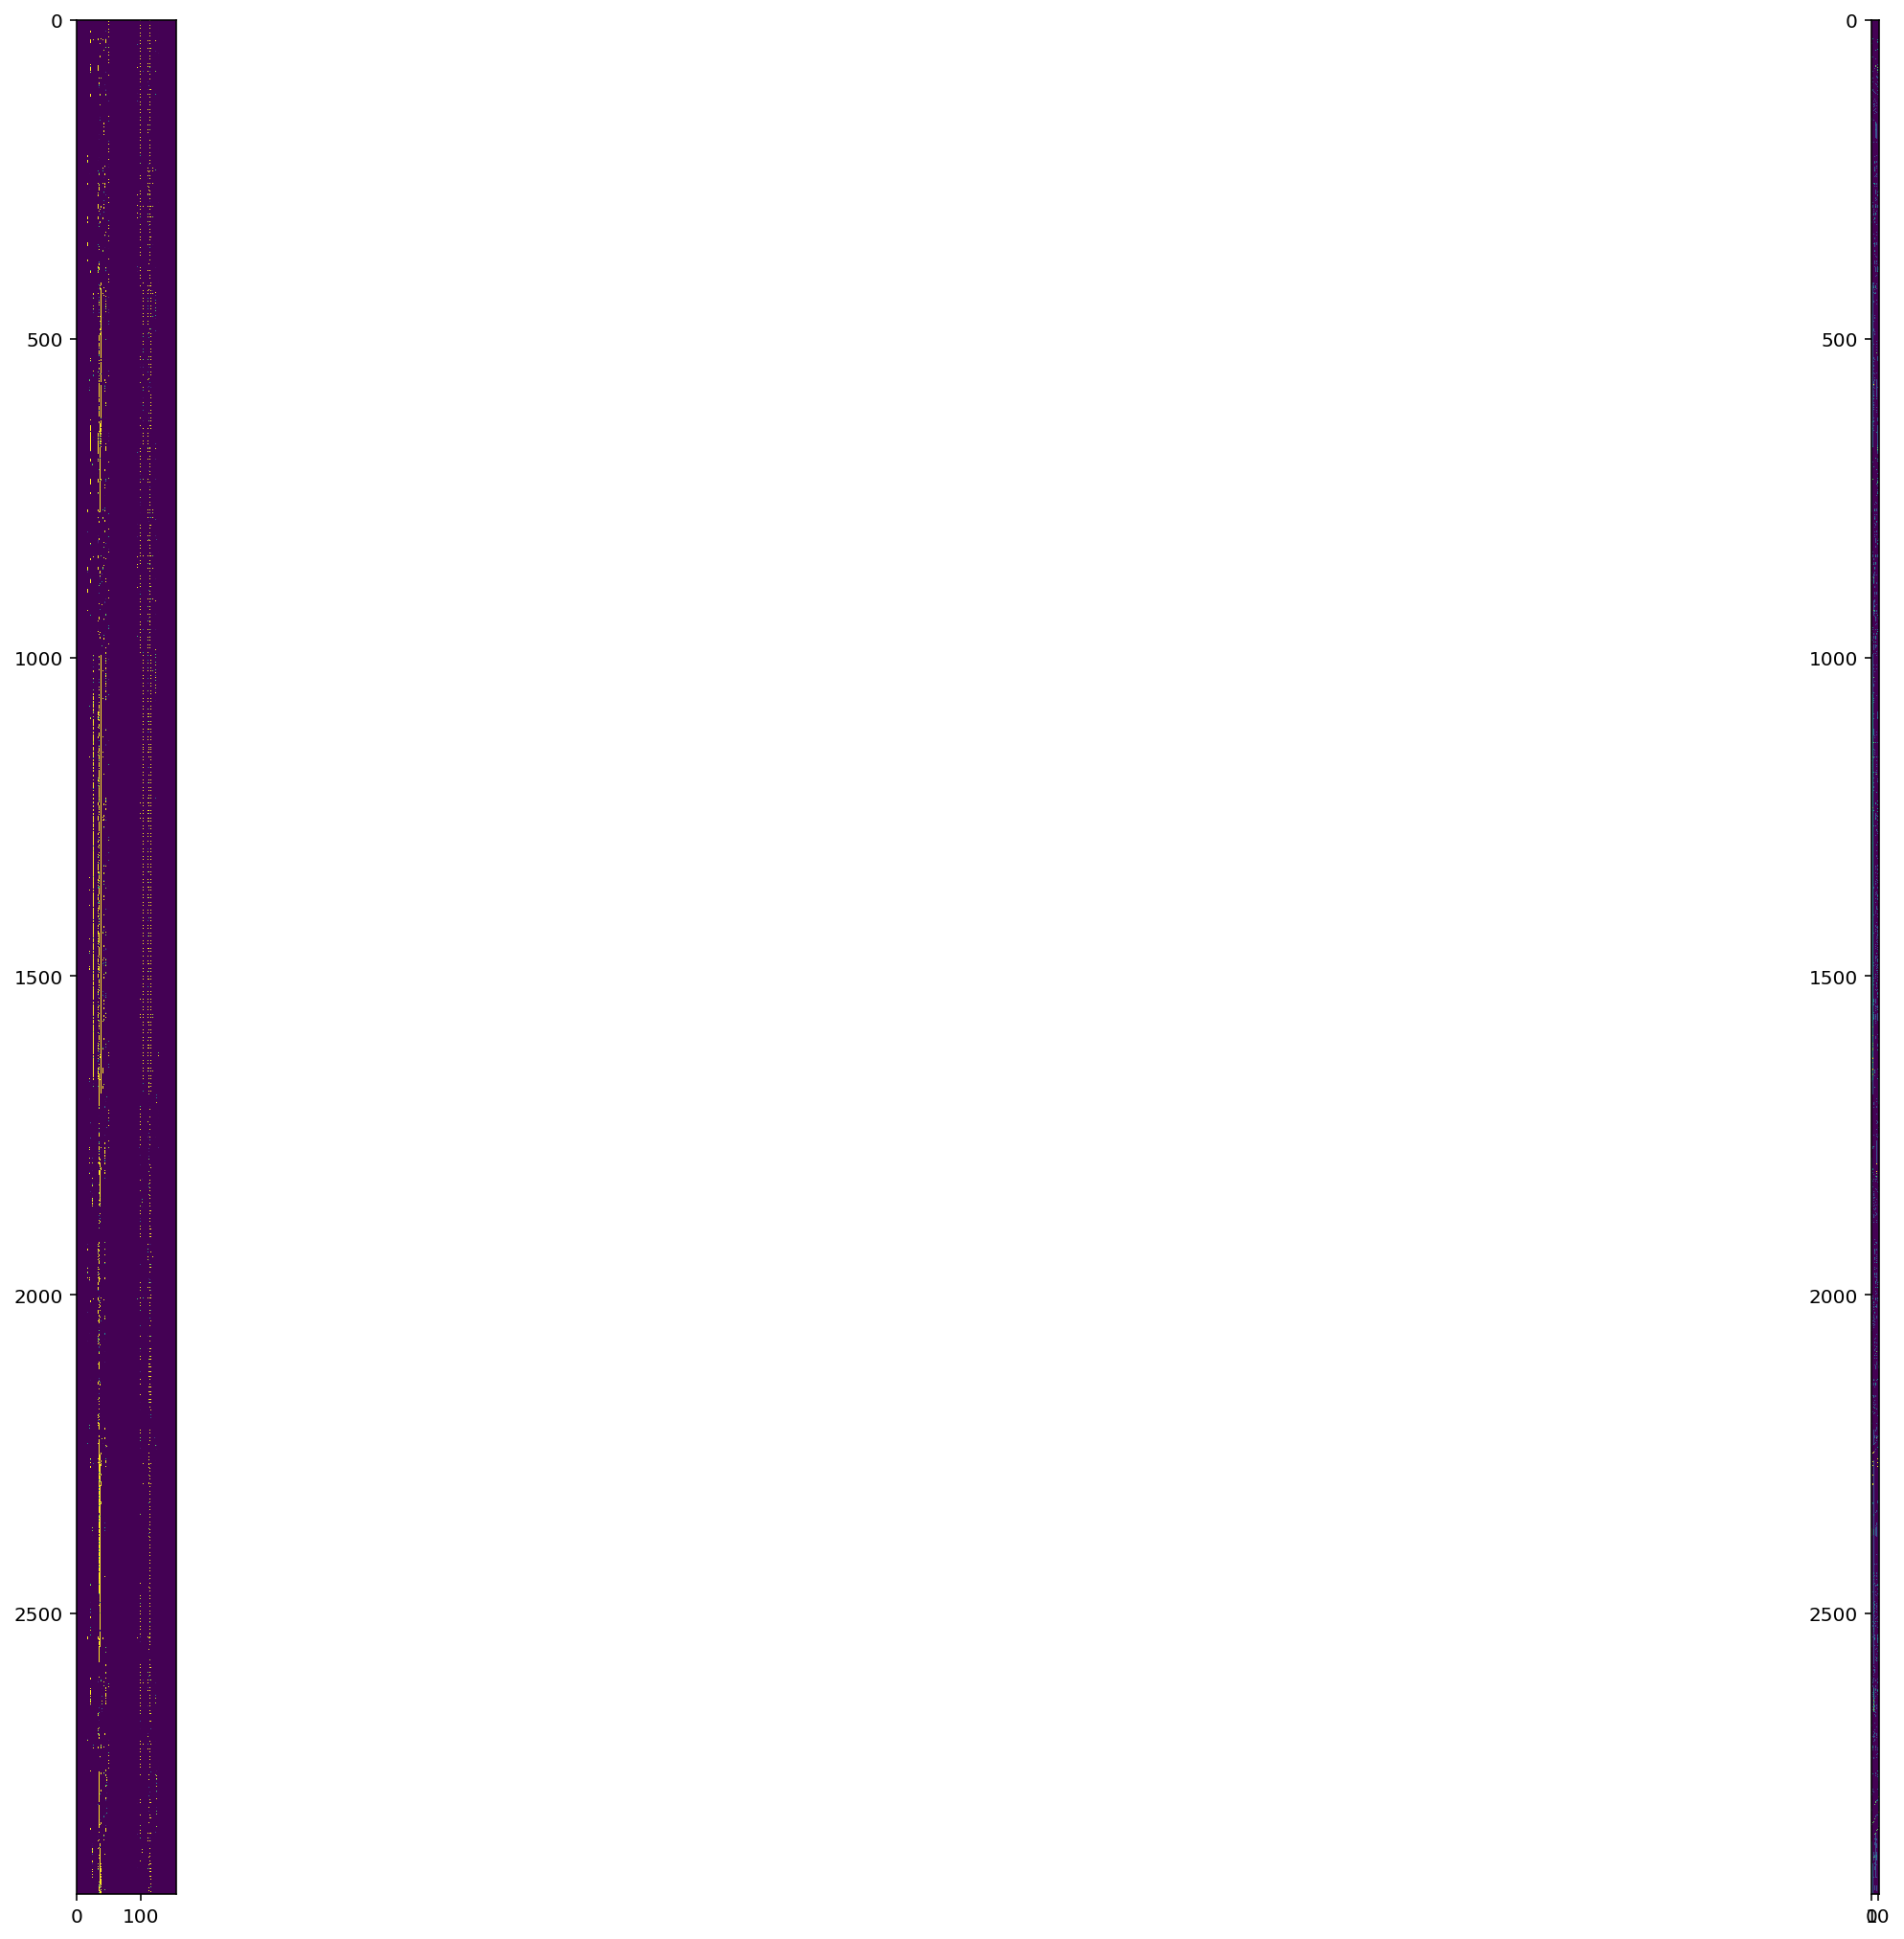

2940
0.0
10 (5648, 12)
(1418, 48) (6, 624)
24
(5672, 156) (5672, 12)


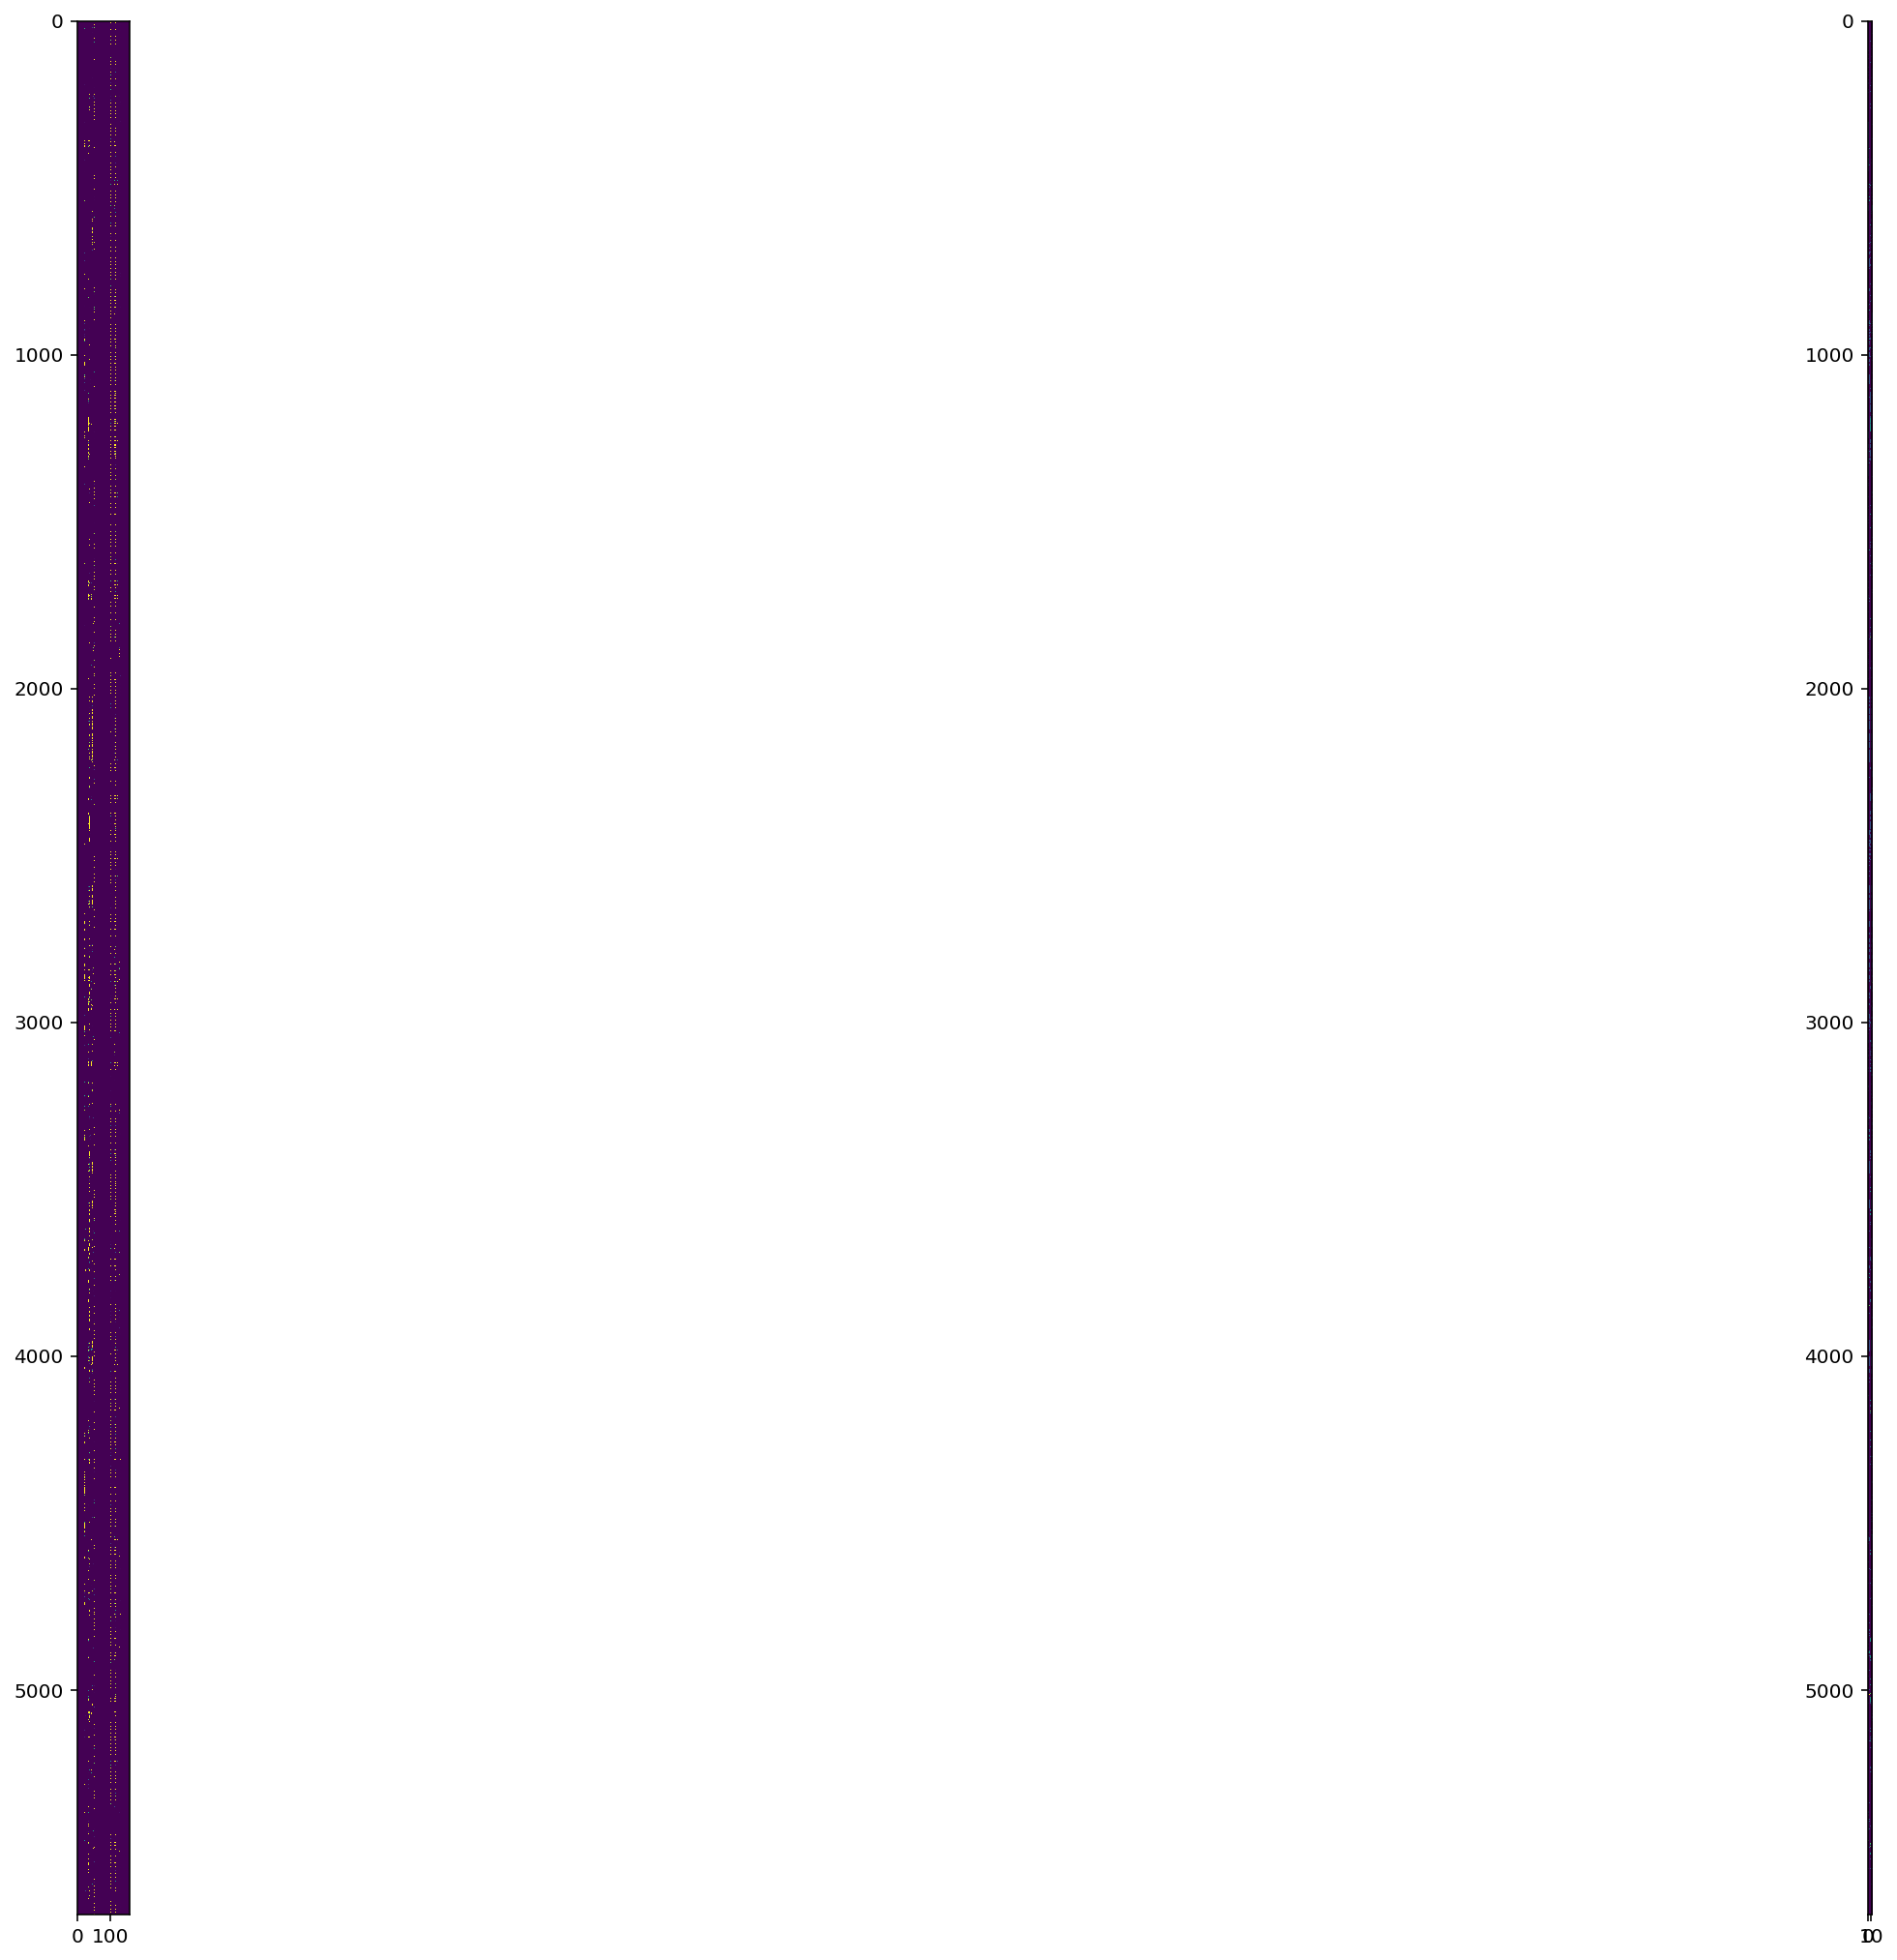

5672


ValueError: operands could not be broadcast together with shapes (6,5672) (6,5648) 

In [39]:
#here should come a chroma from a new song: read a new file, extract chroma and plug into generator
#Since we do not have yet a new song, let's just reuse existing chroma
# test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
# test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])

i = 0

for c in test_chromaz:
    test_chroma = np.array(c)
    save_test_chroma = test_chroma[:5648, :12]
    print(i, np.shape(save_test_chroma))
    

    test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
    test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])
    #chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])
       
    out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})
    print(np.shape(test_chroma),np.shape(samples))
    
    print(np.floor(samples.shape[0]*samples.shape[1]/2/note_range).astype(int))
    
    S = np.reshape(out_samples, (np.floor(out_samples.shape[0]*out_samples.shape[1]/2/note_range).astype(int), 2*note_range))
    C = np.reshape(test_chroma, (test_chroma.shape[0]*num_timesteps, 12))
    print(np.shape(S), np.shape(C))
    thresh_S = S>=0.5
    plt.figure(figsize=(30,18))
    plt.subplot(1,2,1)
    plt.imshow(S)
    plt.subplot(1,2,2)
    plt.imshow(C)
    #plt.tight_layout()
    plt.pause(0.1)
    midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
    i+=1

    x = np.shape(C)[0]
    print(x)
    print(distance(save_test_chroma[:x, :12], C))
    #  print(i)
    
    

8


(968, 156) (968, 12)


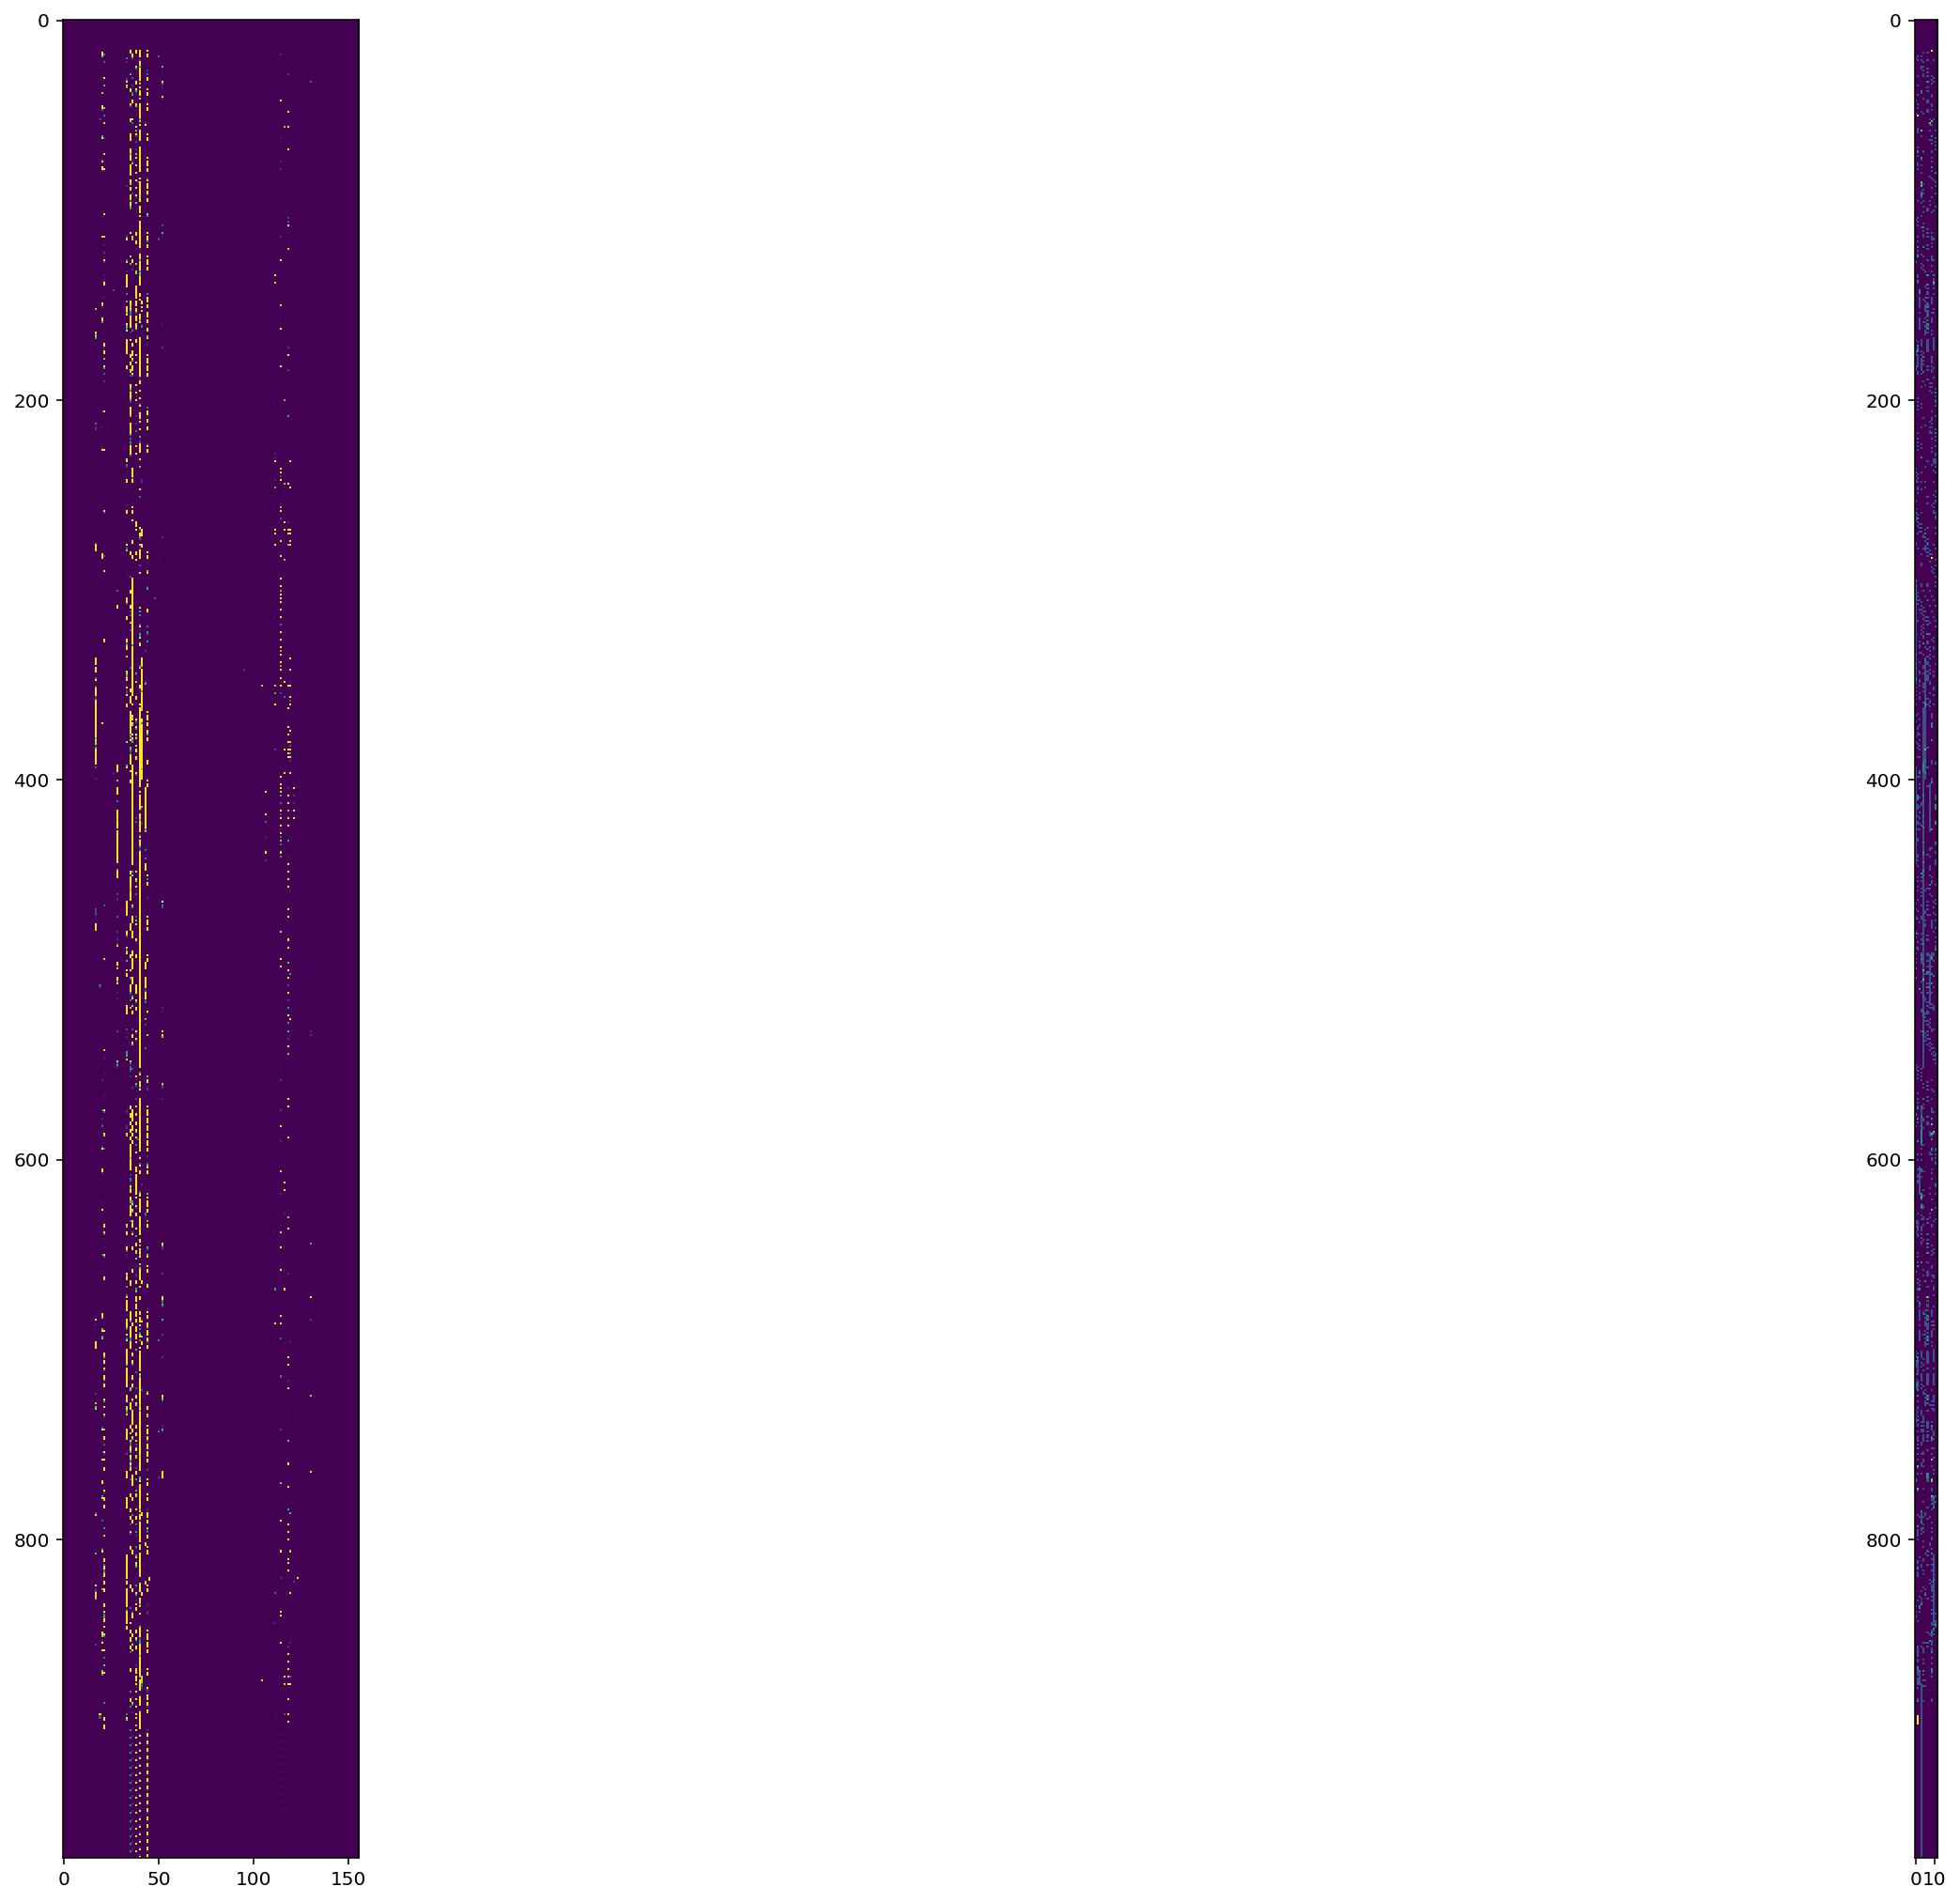

968
0.0


In [84]:
for c in chromas:
    x = np.shape(c)[0]
    print(distance(c, C[:x, :12]))

0.03579206395275058
0.03148105599913731
0.05832851343222978
0.05753177588667882
0.0405498463044164
0.05408971009391601
0.05536261086318998
0.037392845356717545
0.042117135957670845
0.09895334127809999
0.056976677715820996
0.09708488912930022
0.055157769605992654
0.05265357844537241
0.05265357844537241
0.05705561650124494
0.05664543313787168
0.06038901868818484
0.038303425175755704
0.09562020743676253
0.0392482177730478
0.06239529029722166
0.030283029543976898
0.09706322878453633
0.09482605484576746
0.04833078058642885
0.05497908916714546
0.036961377294912716
0.05816918279782267
0.03313770984047764
0.054407953356902634
0.05416051171517844
0.0599880438453723
0.0367907480591741
0.05622772906741244
0.06019696480628676
0.03823936134238069
0.06555510164061541
0.03916349056737568
0.0642390192983852
0.09947264370562708
0.05903196711094722
0.05138061399414355
0.05219097768559637
0.05718936409871315
0.05085922992516703
0.03881372778183543
0.039463384502800826
0.05881750318166887
0.05597710530761

12
